In [17]:
## Install required packages
!pip install torch-snippets
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 24.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.4/226.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 92.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 79.9 MB/s eta 0:00:00:00:01
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=3e9e71674e159eece1c846cab3292cddde346a5ce0224b11eadb002de

# Dataset Analysis

In [18]:
# Import Libraries and Setup
import os
import torch, torch.nn as nn
from torchsummary import summary
from torch_snippets import *
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import mlflow
import mlflow.pytorch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using: {DEVICE}')

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using: cuda


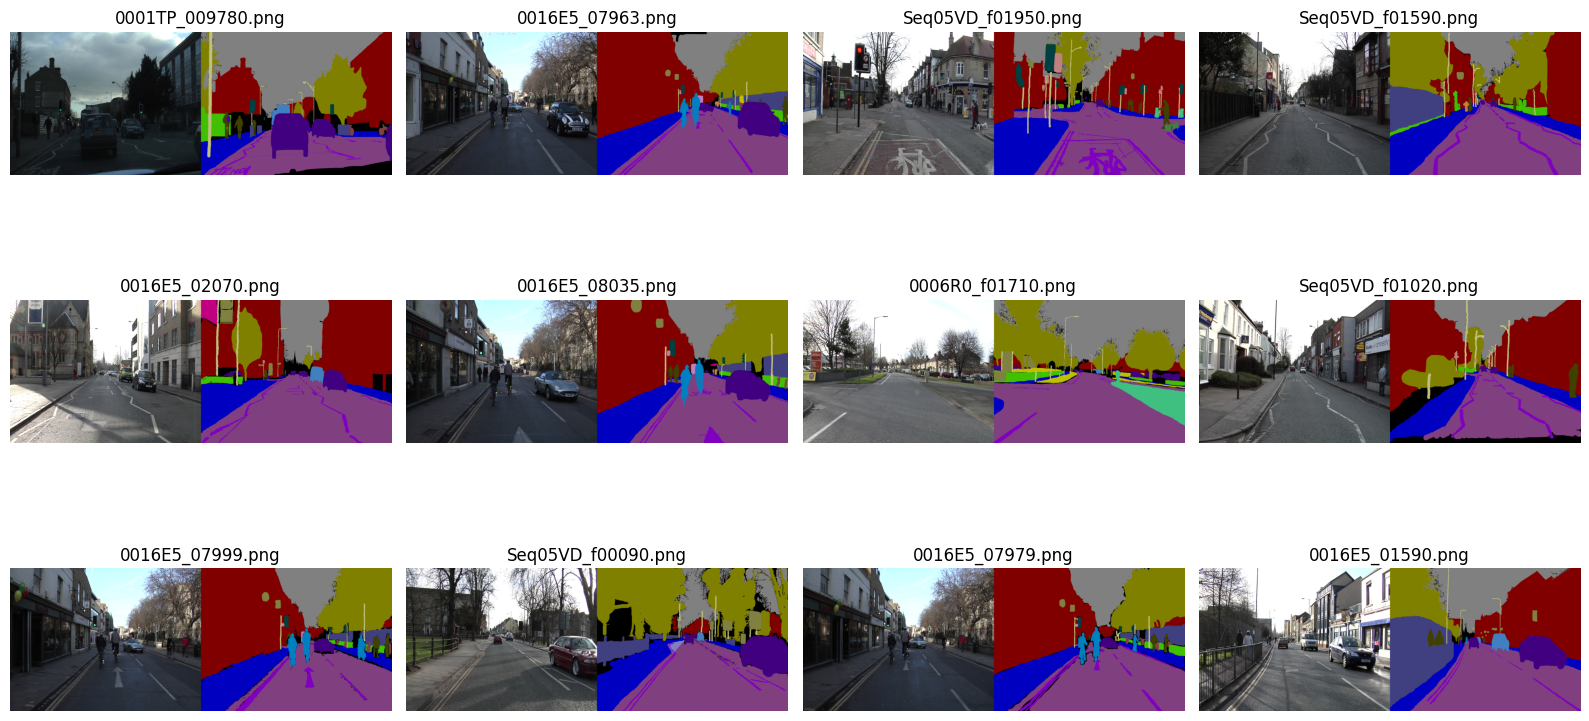

Zip file saved at: /kaggle/working/visualized_samples.zip


In [19]:
#Visualize Sample Images with Masks and save output as zip file

import shutil

DATA_DIR = "/kaggle/input/camvid/CamVid"

#Visualize Sample Images with Masks

nrows, ncols = 3, 4
plt.figure(figsize=(ncols*4, nrows*3))
count = 0

# Create output directory
SAVE_DIR = "/kaggle/working/visualized_samples"
os.makedirs(SAVE_DIR, exist_ok=True)

for id in os.listdir(os.path.join(DATA_DIR, 'train')):
    if count == nrows * ncols:
        break
    count += 1
    img_path = os.path.join(DATA_DIR, 'train', id)
    mask_path = os.path.join(DATA_DIR, 'train_labels', id[:-4] + '_L.png')
    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('RGB')
    
    combined = np.hstack([img, mask])

    # Save the combined image
    save_path = os.path.join(SAVE_DIR, id)
    Image.fromarray(combined).save(save_path)

    plt.subplot(nrows, ncols, count)
    plt.title(id)
    plt.axis('off')
    plt.imshow(combined)

plt.tight_layout()
plt.show()

ZIP_PATH = "/kaggle/working/visualized_samples.zip"
shutil.make_archive("/kaggle/working/visualized_samples", 'zip', SAVE_DIR)

print("Zip file saved at:", ZIP_PATH)

In [20]:
# Check if some images are missing masks

splits = ['train', 'test', 'val']

for split in splits:
    images_dir = os.path.join(DATA_DIR, split)
    masks_dir = os.path.join(DATA_DIR, split + '_labels')

    print(f'Number of images in {split} subset: {len(os.listdir(images_dir))}')
    print(f'Number of masks in {split} subset: {len(os.listdir(masks_dir))}')
    print('-----------------------------------------')

Number of images in train subset: 369
Number of masks in train subset: 369
-----------------------------------------
Number of images in test subset: 232
Number of masks in test subset: 232
-----------------------------------------
Number of images in val subset: 100
Number of masks in val subset: 100
-----------------------------------------


In [21]:
#Define CamVid Color to Class Mapping

camvid_classes = {
    (64, 128, 64): "Animal",
    (192, 0, 128): "Archway",
    (0, 128, 192): "Bicyclist",
    (0, 128, 64): "Bridge",
    (128, 0, 0): "Building",
    (64, 0, 128): "Car",
    (64, 0, 192): "CartLuggagePram",
    (192, 128, 64): "Child",
    (192, 192, 128): "Column_Pole",
    (64, 64, 128): "Fence",
    (128, 0, 192): "LaneMkgsDriv",
    (192, 0, 64): "LaneMkgsNonDriv",
    (128, 128, 64): "Misc_Text",
    (192, 0, 192): "MotorcycleScooter",
    (128, 64, 64): "OtherMoving",
    (64, 192, 128): "ParkingBlock",
    (64, 64, 0): "Pedestrian",
    (128, 64, 128): "Road",
    (128, 128, 192): "RoadShoulder",
    (0, 0, 192): "Sidewalk",
    (192, 128, 128): "SignSymbol",
    (128, 128, 128): "Sky",
    (64, 128, 192): "SUVPickupTruck",
    (0, 0, 64): "TrafficCone",
    (0, 64, 64): "TrafficLight",
    (192, 64, 128): "Train",
    (128, 128, 0): "Tree",
    (192, 128, 192): "Truck_Bus",
    (64, 0, 64): "Tunnel",
    (192, 192, 0): "VegetationMisc",
    (0, 0, 0): "Void",
    (64, 192, 0): "Wall"
}

print("\nColor to Class Mapping:")
print("-" * 50)
for color in sorted(camvid_classes.keys()):
    label = camvid_classes.get(color, 'Unknown')
    print(f"RGB{color} -> {label}")


Color to Class Mapping:
--------------------------------------------------
RGB(0, 0, 0) -> Void
RGB(0, 0, 64) -> TrafficCone
RGB(0, 0, 192) -> Sidewalk
RGB(0, 64, 64) -> TrafficLight
RGB(0, 128, 64) -> Bridge
RGB(0, 128, 192) -> Bicyclist
RGB(64, 0, 64) -> Tunnel
RGB(64, 0, 128) -> Car
RGB(64, 0, 192) -> CartLuggagePram
RGB(64, 64, 0) -> Pedestrian
RGB(64, 64, 128) -> Fence
RGB(64, 128, 64) -> Animal
RGB(64, 128, 192) -> SUVPickupTruck
RGB(64, 192, 0) -> Wall
RGB(64, 192, 128) -> ParkingBlock
RGB(128, 0, 0) -> Building
RGB(128, 0, 192) -> LaneMkgsDriv
RGB(128, 64, 64) -> OtherMoving
RGB(128, 64, 128) -> Road
RGB(128, 128, 0) -> Tree
RGB(128, 128, 64) -> Misc_Text
RGB(128, 128, 128) -> Sky
RGB(128, 128, 192) -> RoadShoulder
RGB(192, 0, 64) -> LaneMkgsNonDriv
RGB(192, 0, 128) -> Archway
RGB(192, 0, 192) -> MotorcycleScooter
RGB(192, 64, 128) -> Train
RGB(192, 128, 64) -> Child
RGB(192, 128, 128) -> SignSymbol
RGB(192, 128, 192) -> Truck_Bus
RGB(192, 192, 0) -> VegetationMisc
RGB(192, 19

In [22]:
#Calculate Class Frequencies 

print("\n\nCalculating Class Frequencies...")
print("-" * 50)

class_counts = defaultdict(int)
train_labels_path = os.path.join(DATA_DIR, 'train_labels')
label_files = os.listdir(train_labels_path)
total_images = len(label_files)

print(f"Processing {total_images} images...")

for idx, id in enumerate(label_files, 1):
    if idx % 50 == 0:  # Progress indicator
        print(f"Processed {idx}/{total_images} images...")
    
    mask_path = os.path.join(train_labels_path, id)
    mask = np.array(Image.open(mask_path).convert('RGB'))
    
    # Get unique colors efficiently
    mask_reshaped = mask.reshape(-1, 3)
    unique_colors = np.unique(mask_reshaped, axis=0)
    
    # Use set to avoid counting same class twice in one image
    for color in unique_colors:
        color_tuple = tuple(color)
        if color_tuple in camvid_classes:
            class_counts[camvid_classes[color_tuple]] += 1

print(f"Processing complete!\n")



Calculating Class Frequencies...
--------------------------------------------------
Processing 369 images...
Processed 50/369 images...
Processed 100/369 images...
Processed 150/369 images...
Processed 200/369 images...
Processed 250/369 images...
Processed 300/369 images...
Processed 350/369 images...
Processing complete!



In [23]:
#Display Results

print("\nClass Frequencies in Training Dataset (Image-level):")
print("-" * 50)

# Sort by frequency (descending)
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

for label, count in sorted_classes:
    percentage = (count / total_images) * 100
    print(f"{label:25s}: {count:4d} images ({percentage:5.1f}%)")

print(f"\nTotal training images: {total_images}")
print(f"Total unique classes found: {len(class_counts)}")


Class Frequencies in Training Dataset (Image-level):
--------------------------------------------------
Void                     :  369 images (100.0%)
Road                     :  369 images (100.0%)
Sky                      :  367 images ( 99.5%)
Column_Pole              :  367 images ( 99.5%)
LaneMkgsDriv             :  366 images ( 99.2%)
Building                 :  363 images ( 98.4%)
Sidewalk                 :  353 images ( 95.7%)
Car                      :  333 images ( 90.2%)
Pedestrian               :  332 images ( 90.0%)
Tree                     :  329 images ( 89.2%)
Misc_Text                :  317 images ( 85.9%)
Wall                     :  241 images ( 65.3%)
OtherMoving              :  239 images ( 64.8%)
SignSymbol               :  233 images ( 63.1%)
TrafficLight             :  229 images ( 62.1%)
Fence                    :  212 images ( 57.5%)
Bicyclist                :  179 images ( 48.5%)
VegetationMisc           :  156 images ( 42.3%)
SUVPickupTruck           :  124

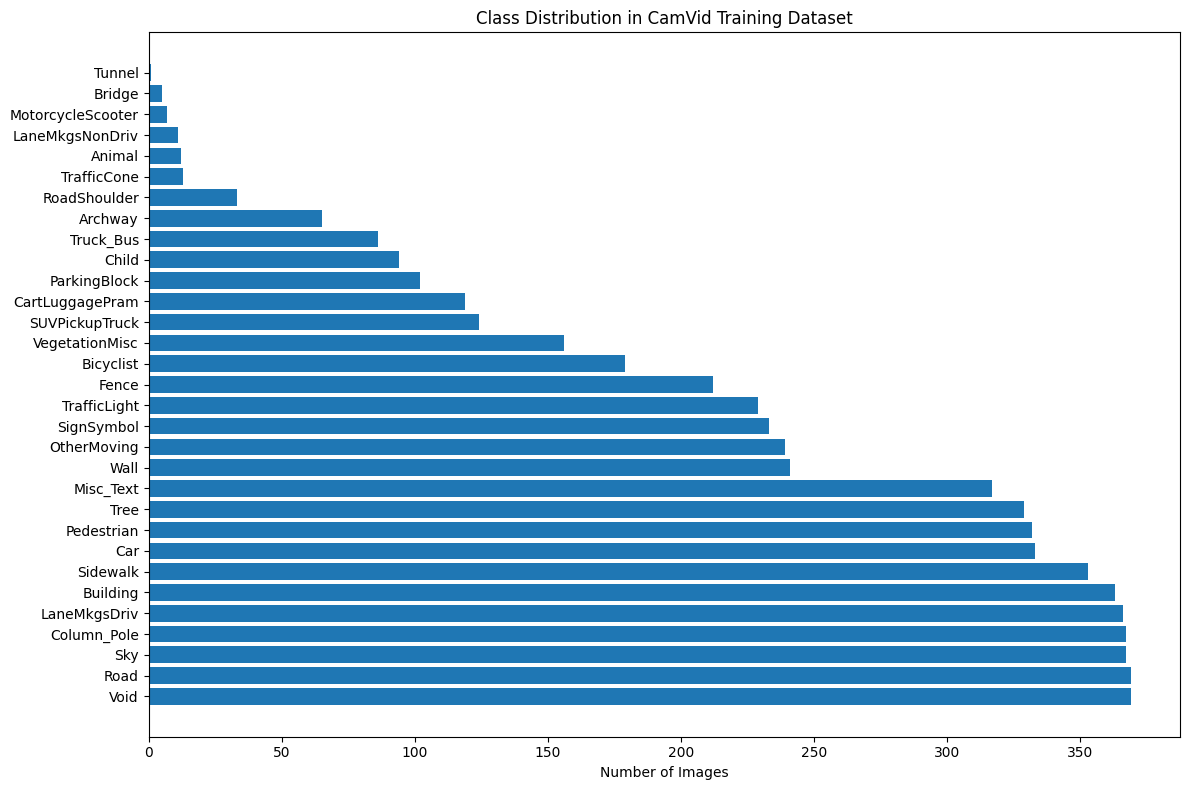

In [24]:
#Visualize Class Distribution

plt.figure(figsize=(12, 8))
labels, counts = zip(*sorted_classes)
plt.barh(range(len(labels)), counts)
plt.yticks(range(len(labels)), labels)
plt.xlabel('Number of Images')
plt.title('Class Distribution in CamVid Training Dataset')
plt.tight_layout()

# Save the figure
plt.savefig("class_distribution.png", dpi=300, bbox_inches='tight')

plt.show()

# Dataset Preprocessing

In [25]:
# Merge 32 classes into 12 simplified classes for autonomous driving

class_merge_mapping = {
    # Ignore class
    "Void": "Ignore",
    
    # Road infrastructure
    "Road": "Road",
    "RoadShoulder": "Road",
    "LaneMkgsDriv": "Road",
    "LaneMkgsNonDriv": "Road",
    
    # Walkable areas
    "Sidewalk": "Sidewalk",
    "ParkingBlock": "Sidewalk",
    
    # Sky
    "Sky": "Sky",
    
    # Buildings and structures
    "Building": "Building",
    "Wall": "Building",
    "Fence": "Building",
    "Tunnel": "Building",
    "Bridge": "Building",
    "Archway": "Building",
    
    # Vegetation
    "Tree": "Vegetation",
    "VegetationMisc": "Vegetation",
    
    # Vehicles
    "Car": "Vehicle",
    "SUVPickupTruck": "Vehicle",
    "Truck_Bus": "Vehicle",
    "Train": "Vehicle",
    
    # Vulnerable road users
    "Pedestrian": "Person",
    "Child": "Person",
    "Bicyclist": "Cyclist",
    "MotorcycleScooter": "Cyclist",
    
    # Street furniture
    "Column_Pole": "Pole",
    "TrafficLight": "TrafficLight",
    "TrafficCone": "TrafficSign",
    "SignSymbol": "TrafficSign",
    "Misc_Text": "TrafficSign",
    
    # Moving objects
    "CartLuggagePram": "Object",
    "OtherMoving": "Object",
    "Animal": "Object"

}

In [26]:
# Create merged class list with IDs
merged_classes = {
    "Ignore": 0,
    "Road": 1,
    "Sidewalk": 2,
    "Building": 3,
    "Pole": 4,
    "TrafficLight": 5,
    "TrafficSign": 6,
    "Vegetation": 7,
    "Sky": 8,
    "Person": 9,
    "Cyclist": 10,
    "Vehicle": 11,
    "Object": 12
}

print("Merged Class Mapping:")
print("-" * 50)
for merged_class, class_id in merged_classes.items():
    print(f"{class_id:2d}: {merged_class}")

Merged Class Mapping:
--------------------------------------------------
 0: Ignore
 1: Road
 2: Sidewalk
 3: Building
 4: Pole
 5: TrafficLight
 6: TrafficSign
 7: Vegetation
 8: Sky
 9: Person
10: Cyclist
11: Vehicle
12: Object


In [27]:
#Create Color to Merged Class ID Mapping

color_to_merged_id = {}

for color, original_class in camvid_classes.items():
    merged_class = class_merge_mapping[original_class]
    merged_id = merged_classes[merged_class]
    color_to_merged_id[color] = merged_id

print(f"\nTotal color mappings created: {len(color_to_merged_id)}")


Total color mappings created: 32


In [28]:
# Function to Convert RGB Mask to Class ID Mask

def convert_rgb_mask_to_ids(rgb_mask, color_to_id_map):
    
    height, width, _ = rgb_mask.shape
    id_mask = np.zeros((height, width), dtype=np.uint8)
    
    for color, class_id in color_to_id_map.items():
        mask = np.all(rgb_mask == color, axis=-1)
        id_mask[mask] = class_id
    
    return id_mask

In [29]:
# Process and Save Preprocessed Masks

def preprocess_dataset(data_dir, output_dir, split='train'):
    input_mask_dir = os.path.join(data_dir, f'{split}_labels')
    output_mask_dir = os.path.join(output_dir, f'{split}_labels_processed')
    
    os.makedirs(output_mask_dir, exist_ok=True)
    
    mask_files = os.listdir(input_mask_dir)
    total_files = len(mask_files)
    
    print(f"\nProcessing {split} set: {total_files} masks")
    print("=" * 50)
    
    for idx, filename in enumerate(mask_files, 1):
        if idx % 50 == 0:
            print(f"Processed {idx}/{total_files} masks...")
        
        # Load RGB mask
        mask_path = os.path.join(input_mask_dir, filename)
        rgb_mask = np.array(Image.open(mask_path).convert('RGB'))
        
        # Convert to class IDs
        id_mask = convert_rgb_mask_to_ids(rgb_mask, color_to_merged_id)
        
        # Save as PNG
        output_path = os.path.join(output_mask_dir, filename)
        Image.fromarray(id_mask).save(output_path)
    
    print(f"Completed: Saved {total_files} preprocessed masks to {output_mask_dir}")
    return output_mask_dir

In [30]:
# Calculate New Class Distribution

def calculate_merged_class_distribution(processed_mask_dir):
   
    class_pixel_counts = defaultdict(int)
    mask_files = os.listdir(processed_mask_dir)
    
    print("\nCalculating merged class distribution...")
    print("=" * 50)
    
    for idx, filename in enumerate(mask_files, 1):
        if idx % 50 == 0:
            print(f"Analyzed {idx}/{len(mask_files)} masks...")
        
        mask_path = os.path.join(processed_mask_dir, filename)
        mask = np.array(Image.open(mask_path))
        
        unique, counts = np.unique(mask, return_counts=True)
        for class_id, count in zip(unique, counts):
            class_pixel_counts[class_id] += count
    
    return class_pixel_counts


def display_class_distribution(class_pixel_counts, merged_classes):
    
    id_to_class = {v: k for k, v in merged_classes.items()}
    total_pixels = sum(class_pixel_counts.values())
    
    print("\nMerged Class Distribution (Pixel-level):")
    print("=" * 50)
    
    sorted_counts = sorted(class_pixel_counts.items(), key=lambda x: x[1], reverse=True)
    
    for class_id, pixel_count in sorted_counts:
        class_name = id_to_class.get(class_id, f"Unknown_{class_id}")
        percentage = (pixel_count / total_pixels) * 100
        print(f"{class_name:15s} (ID {class_id:2d}): {pixel_count:10d} pixels ({percentage:5.2f}%)")
    
    print(f"\nTotal pixels: {total_pixels:,}")

In [31]:
#Visualize Original vs Preprocessed Masks

def visualize_comparison(data_dir, processed_mask_dir, num_samples=4):
    """
    Visualize original RGB masks vs preprocessed class ID masks.
    
    Args:
        data_dir: path to CamVid dataset
        processed_mask_dir: path to preprocessed masks
        num_samples: number of samples to display
    """
    original_mask_dir = os.path.join(data_dir, 'train_labels')
    mask_files = os.listdir(original_mask_dir)[:num_samples]
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, num_samples*3))
    
    for idx, filename in enumerate(mask_files):
        # Load original RGB mask
        original_path = os.path.join(original_mask_dir, filename)
        original_mask = Image.open(original_path).convert('RGB')
        
        # Load preprocessed ID mask
        processed_path = os.path.join(processed_mask_dir, filename)
        processed_mask = np.array(Image.open(processed_path))
        
        # Display
        axes[idx, 0].imshow(original_mask)
        axes[idx, 0].set_title(f'Original RGB Mask - {filename}')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(processed_mask, cmap='tab20')
        axes[idx, 1].set_title(f'Preprocessed Class IDs (13 classes)')
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


Processing train set: 369 masks
Processed 50/369 masks...
Processed 100/369 masks...
Processed 150/369 masks...
Processed 200/369 masks...
Processed 250/369 masks...
Processed 300/369 masks...
Processed 350/369 masks...
Completed: Saved 369 preprocessed masks to /kaggle/working/camvid_preprocessed/train_labels_processed

Processing val set: 100 masks
Processed 50/100 masks...
Processed 100/100 masks...
Completed: Saved 100 preprocessed masks to /kaggle/working/camvid_preprocessed/val_labels_processed

Processing test set: 232 masks
Processed 50/232 masks...
Processed 100/232 masks...
Processed 150/232 masks...
Processed 200/232 masks...
Completed: Saved 232 preprocessed masks to /kaggle/working/camvid_preprocessed/test_labels_processed

Calculating merged class distribution...
Analyzed 50/369 masks...
Analyzed 100/369 masks...
Analyzed 150/369 masks...
Analyzed 200/369 masks...
Analyzed 250/369 masks...
Analyzed 300/369 masks...
Analyzed 350/369 masks...

Merged Class Distribution (Pi

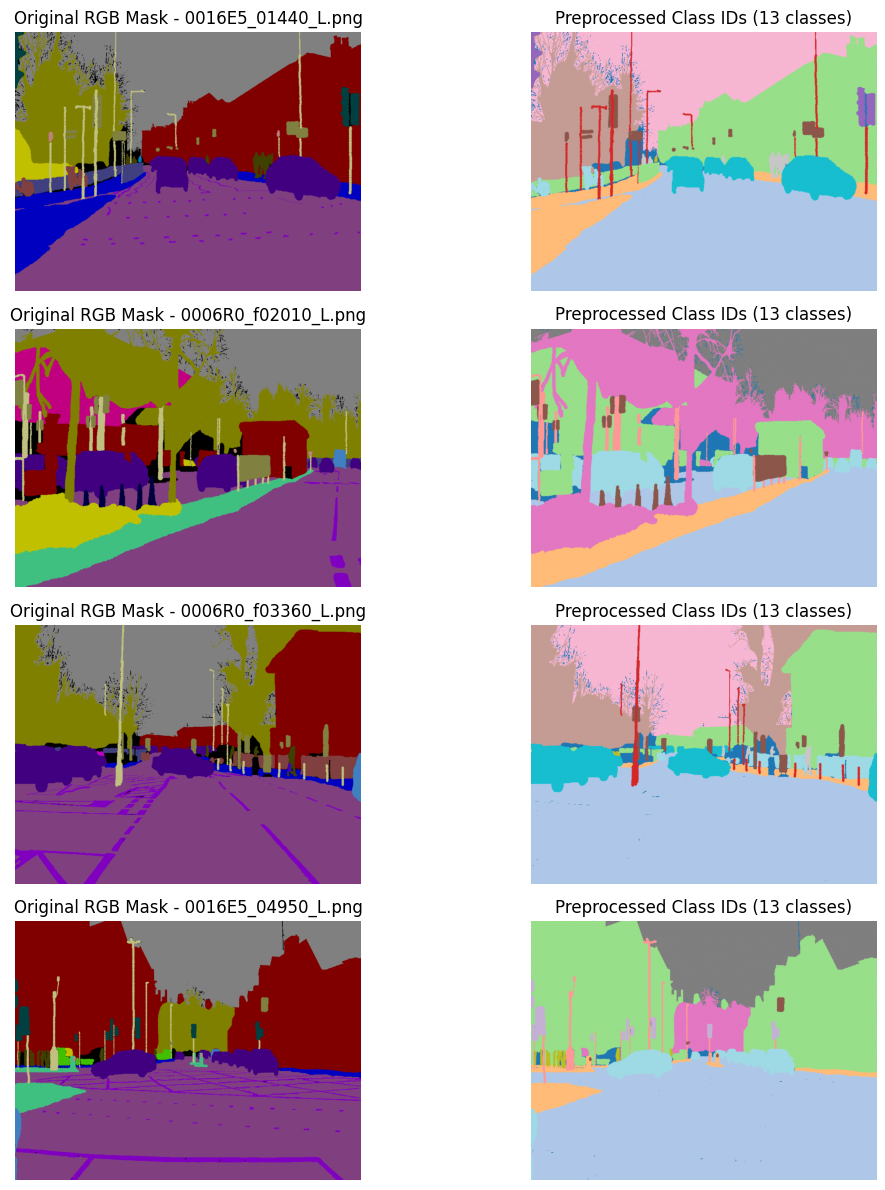


Preprocessing complete!
Preprocessed masks saved to: /kaggle/working/camvid_preprocessed


In [32]:
#Main Execution

if __name__ == "__main__":
    # Configuration
    DATA_DIR = "/kaggle/input/camvid/CamVid"
    OUTPUT_DIR = "/kaggle/working/camvid_preprocessed"
    
    # Process train set
    processed_train_dir = preprocess_dataset(DATA_DIR, OUTPUT_DIR, split='train')

    # Process val set
    processed_val_dir = preprocess_dataset(DATA_DIR, OUTPUT_DIR, split='val')

    # Process test set
    processed_test_dir = preprocess_dataset(DATA_DIR, OUTPUT_DIR, split='test')
    
    # Calculate and display distribution
    class_counts = calculate_merged_class_distribution(processed_train_dir)
    display_class_distribution(class_counts, merged_classes)
    
    # Visualize comparison
    visualize_comparison(DATA_DIR, processed_train_dir, num_samples=4)
    
    print("\nPreprocessing complete!")
    print(f"Preprocessed masks saved to: {OUTPUT_DIR}")

# Training Loop

In [33]:
!pip install segmentation-models-pytorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:0000:01


In [66]:
import torch.optim as optim
import segmentation_models_pytorch as smp
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [67]:
#Hyperparameter Search Space
import random


HYPERPARAM_SEARCH_SPACE = {
    'learning_rate': [1e-5, 5e-4, 1e-3],
    'batch_size': [4, 8],
    'optimizer': ['Adam', 'AdamW'],
    'weight_decay': [1e-5, 1e-4, 5e-4],
    'lr_scheduler': ['reduce_on_plateau', 'cosine']
}

def sample_hyperparameters():
    """Sample random hyperparameters from search space."""
    return {
        'learning_rate': random.choice(HYPERPARAM_SEARCH_SPACE['learning_rate']),
        'batch_size': random.choice(HYPERPARAM_SEARCH_SPACE['batch_size']),
        'optimizer': random.choice(HYPERPARAM_SEARCH_SPACE['optimizer']),
        'weight_decay': random.choice(HYPERPARAM_SEARCH_SPACE['weight_decay']),
        'lr_scheduler': random.choice(HYPERPARAM_SEARCH_SPACE['lr_scheduler'])
    }

In [68]:
# Configuration

class Config:
    # Paths
    DATA_DIR = "/kaggle/input/camvid/CamVid"
    PROCESSED_DIR = "/kaggle/working/camvid_preprocessed"
    CHECKPOINT_DIR = "/kaggle/working/checkpoints"
    
    # Model Selection - CHANGE HERE TO SWITCH MODELS
    MODEL_NAME = "unet"  # Options: 'unet', 'deeplabv3plus', 'fpn', 'unetplusplus'
    ENCODER_NAME = "resnet50"  # Options: 'resnet50', 'resnet101', 'efficientnet-b0', 'mobilenet_v2'
    ENCODER_WEIGHTS = "imagenet"  # Use pretrained weights
    
    # Dataset
    NUM_CLASSES = 13
    IMAGE_HEIGHT = 480
    IMAGE_WIDTH = 640
    
    # Training
    BATCH_SIZE = 8
    NUM_EPOCHS = 20
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4
    
    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Early stopping
    EARLY_STOPPING_PATIENCE = 15
    
    # LR Scheduler
    LR_SCHEDULER = "reduce_on_plateau"  # Options: 'reduce_on_plateau', 'cosine', 'one_cycle'
    LR_PATIENCE = 5
    LR_FACTOR = 0.5
    
    # Class weights (will be calculated from data)
    CLASS_WEIGHTS = None
    
    # Random seed
    SEED = 42

# Set random seeds
torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

# Create checkpoint directory
os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

print(f"Configuration loaded")
print(f"Device: {Config.DEVICE}")
print(f"Model: {Config.MODEL_NAME} with {Config.ENCODER_NAME} encoder")

Configuration loaded
Device: cuda
Model: unet with resnet50 encoder


In [69]:
import mlflow
#Dataset Class

class CamVidDataset(Dataset):
    def __init__(self, data_dir, processed_dir, split='train', transform=None):
        self.image_dir = os.path.join(data_dir, split)
        self.mask_dir = os.path.join(processed_dir, f'{split}_labels_processed')
        self.transform = transform
        
        # Get all image files
        self.images = sorted(os.listdir(self.image_dir))
        
        # Filter only images that have corresponding masks
        self.valid_images = []
        for img_name in self.images:
            mask_name = img_name[:-4] + '_L.png'
            mask_path = os.path.join(self.mask_dir, mask_name)
            if os.path.exists(mask_path):
                self.valid_images.append((img_name, mask_name))
        
        print(f"{split} dataset: {len(self.valid_images)} samples")
    
    def __len__(self):
        return len(self.valid_images)
    
    def __getitem__(self, idx):
        img_name, mask_name = self.valid_images[idx]
        
        # Load image
        img_path = os.path.join(self.image_dir, img_name)
        image = np.array(Image.open(img_path).convert('RGB'))
        
        # Load mask
        mask_path = os.path.join(self.mask_dir, mask_name)
        mask = np.array(Image.open(mask_path))
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask.long()

In [70]:
#Data Augmentation

def get_training_augmentation():
    """
    Training augmentation pipeline.
    """
    train_transform = A.Compose([
        A.Resize(Config.IMAGE_HEIGHT, Config.IMAGE_WIDTH),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.3),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    return train_transform

def get_validation_augmentation():
    """
    Validation augmentation pipeline (only resize and normalize).
    """
    val_transform = A.Compose([
        A.Resize(Config.IMAGE_HEIGHT, Config.IMAGE_WIDTH),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    return val_transform

In [71]:
#Calculate Class Weights
def calculate_class_weights(mask_dir, num_classes, ignore_index=0):
    
    print("\nCalculating class weights...")
    class_counts = np.zeros(num_classes, dtype=np.int64)
    
    mask_files = os.listdir(mask_dir)
    for mask_file in tqdm(mask_files, desc="Analyzing masks"):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = np.array(Image.open(mask_path))
        
        for class_id in range(num_classes):
            class_counts[class_id] += np.sum(mask == class_id)
    
    # Calculate weights using median frequency balancing
    class_counts = class_counts.astype(np.float32)
    class_counts[class_counts == 0] = 1  # Avoid division by zero
    
    median_freq = np.median(class_counts)
    class_weights = median_freq / class_counts
    
    # Set weight for ignore class to 0
    class_weights[ignore_index] = 0.0
    
    print("\nClass weights:")
    for i, weight in enumerate(class_weights):
        print(f"Class {i}: {weight:.4f}")
    
    return torch.FloatTensor(class_weights)

In [72]:
#Model Creation

def create_model(model_name, encoder_name, encoder_weights, num_classes):
   
    if model_name == 'unet':
        model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=num_classes
        )
    
    elif model_name == 'deeplabv3plus':
        model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=num_classes
        )
    
    elif model_name == 'fpn':
        model = smp.FPN(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=num_classes
        )
    
    elif model_name == 'unetplusplus':
        model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=num_classes
        )
    
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    return model

In [73]:
#Loss Function

class SegmentationLoss(nn.Module):
    def __init__(self, class_weights=None, ignore_index=0):
        
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)
    
    def forward(self, predictions, targets):
        return self.ce_loss(predictions, targets)

In [74]:
#Metrics

class IoUMetric:
    def __init__(self, num_classes, ignore_index=0):
        
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.reset()
    
    def reset(self):
        self.intersection = np.zeros(self.num_classes)
        self.union = np.zeros(self.num_classes)
    
    def update(self, predictions, targets):
        
        predictions = torch.argmax(predictions, dim=1)
        predictions = predictions.cpu().numpy()
        targets = targets.cpu().numpy()
        
        for class_id in range(self.num_classes):
            if class_id == self.ignore_index:
                continue
            
            pred_mask = predictions == class_id
            target_mask = targets == class_id
            
            intersection = np.logical_and(pred_mask, target_mask).sum()
            union = np.logical_or(pred_mask, target_mask).sum()
            
            self.intersection[class_id] += intersection
            self.union[class_id] += union
    
    def compute(self):
        
        iou_per_class = np.zeros(self.num_classes)
        valid_classes = 0
        
        for class_id in range(self.num_classes):
            if class_id == self.ignore_index:
                continue
            
            if self.union[class_id] > 0:
                iou_per_class[class_id] = self.intersection[class_id] / self.union[class_id]
                valid_classes += 1
        
        mean_iou = iou_per_class.sum() / valid_classes if valid_classes > 0 else 0
        return mean_iou, iou_per_class

In [75]:
#Training Functions

def train_one_epoch(model, dataloader, criterion, optimizer, device, metric):
    """
    Train for one epoch.
    """
    model.train()
    metric.reset()
    
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Training")
    
    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Update metrics
        running_loss += loss.item()
        metric.update(outputs.detach(), masks.detach())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    # Compute metrics
    mean_iou, class_iou = metric.compute()
    avg_loss = running_loss / len(dataloader)
    
    return avg_loss, mean_iou


def validate(model, dataloader, criterion, device, metric):
    """
    Validate the model.
    """
    model.eval()
    metric.reset()
    
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Validation")
    
    with torch.no_grad():
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Update metrics
            running_loss += loss.item()
            metric.update(outputs, masks)
            
            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})
    
    # Compute metrics
    mean_iou, class_iou = metric.compute()
    avg_loss = running_loss / len(dataloader)
    
    return avg_loss, mean_iou, class_iou

In [76]:
#Learning Rate Scheduler

def get_scheduler(optimizer, scheduler_name, **kwargs):
    
    if scheduler_name == 'reduce_on_plateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            patience=kwargs.get('patience', Config.LR_PATIENCE),
            factor=kwargs.get('factor', Config.LR_FACTOR)
        )
    
    elif scheduler_name == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=kwargs.get('T_max', Config.NUM_EPOCHS),
            eta_min=kwargs.get('eta_min', 1e-6)
        )
    
    elif scheduler_name == 'one_cycle':
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=kwargs.get('max_lr', Config.LEARNING_RATE * 10),
            epochs=kwargs.get('epochs', Config.NUM_EPOCHS),
            steps_per_epoch=kwargs.get('steps_per_epoch', 1)
        )
    
    else:
        raise ValueError(f"Unknown scheduler: {scheduler_name}")
    
    return scheduler

In [85]:
# Calculate Class Weights (One Time)

train_mask_dir = os.path.join(Config.PROCESSED_DIR, 'train_labels_processed')
GLOBAL_CLASS_WEIGHTS = calculate_class_weights(train_mask_dir, Config.NUM_CLASSES, ignore_index=0)
GLOBAL_CLASS_WEIGHTS = GLOBAL_CLASS_WEIGHTS.to(Config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Calculating class weights...


Analyzing masks: 100%|██████████| 369/369 [00:03<00:00, 121.83it/s]


Class weights:
Class 0: 0.0000
Class 1: 0.0856
Class 2: 0.3655
Class 3: 0.1017
Class 4: 2.5338
Class 5: 7.2353
Class 6: 3.3226
Class 7: 0.2398
Class 8: 0.1735
Class 9: 4.0341
Class 10: 5.4845
Class 11: 0.6844
Class 12: 5.2497
Total parameters: 32,522,845
Trainable parameters: 32,522,845


In [86]:
#Main Training Loop

def train_model(hyperparams=None):
    """
    Main training function.
    """
    print("\n" + "="*50)
    print("Starting Training Pipeline")
    
    # Apply hyperparameters if provided
    if hyperparams:
        Config.LEARNING_RATE = hyperparams['learning_rate']
        Config.BATCH_SIZE = hyperparams['batch_size']
        Config.WEIGHT_DECAY = hyperparams['weight_decay']
        Config.LR_SCHEDULER = hyperparams['lr_scheduler']
        optimizer_name = hyperparams['optimizer']
        
        print(f"\nUsing hyperparameters:")
        for key, value in hyperparams.items():
            print(f"  {key}: {value}")
    
    # Create datasets
    train_dataset = CamVidDataset(
        Config.DATA_DIR,
        Config.PROCESSED_DIR,
        split='train',
        transform=get_training_augmentation()
    )
    
    val_dataset = CamVidDataset(
        Config.DATA_DIR,
        Config.PROCESSED_DIR,
        split='val',
        transform=get_validation_augmentation()
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    # Use pre-calculated weights
    class_weights = GLOBAL_CLASS_WEIGHTS
    
    # Create model
    print(f"\nCreating model: {Config.MODEL_NAME} with {Config.ENCODER_NAME}")
    model = create_model(
        Config.MODEL_NAME,
        Config.ENCODER_NAME,
        Config.ENCODER_WEIGHTS,
        Config.NUM_CLASSES
    )
    model = model.to(Config.DEVICE)
    
    # Loss and optimizer
    criterion = SegmentationLoss(class_weights=class_weights, ignore_index=0)
    
    if hyperparams and optimizer_name == 'Adam':
        optimizer = optim.Adam(
            model.parameters(),
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY
        )
    else:
        optimizer = optim.AdamW(
            model.parameters(),
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY
        )
    
    
    # Scheduler
    scheduler = get_scheduler(optimizer, Config.LR_SCHEDULER)
    
    # Metrics
    train_metric = IoUMetric(Config.NUM_CLASSES, ignore_index=0)
    val_metric = IoUMetric(Config.NUM_CLASSES, ignore_index=0)
    
    # Training history
    history = {
        'train_loss': [],
        'train_iou': [],
        'val_loss': [],
        'val_iou': []
    }
    
    # Early stopping
    best_val_iou = 0.0
    epochs_without_improvement = 0
    
    # Training loop
    print("\n" + "="*50)
    print("Training Started")
    print("="*50)
    
    for epoch in range(Config.NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{Config.NUM_EPOCHS}")
        print("-" * 50)
        
        # Train
        train_loss, train_iou = train_one_epoch(
            model, train_loader, criterion, optimizer, Config.DEVICE, train_metric
        )
        
        # Validate
        val_loss, val_iou, class_iou = validate(
            model, val_loader, criterion, Config.DEVICE, val_metric
        )
        
        # Update scheduler
        if Config.LR_SCHEDULER == 'reduce_on_plateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        
        # Print epoch results
        print(f"\nTrain Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save best model
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            epochs_without_improvement = 0
            
            checkpoint_path = os.path.join(
                Config.CHECKPOINT_DIR,
                f'best_model_{Config.MODEL_NAME}_{Config.ENCODER_NAME}.pth'
            )
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou,
                'val_loss': val_loss,
                'class_iou': class_iou
            }, checkpoint_path)
            
            print(f"Saved best model with Val IoU: {val_iou:.4f}")
            print(f"Checkpoint path: {checkpoint_path}")
            print(f"File exists: {os.path.exists(checkpoint_path)}")
        else:
            epochs_without_improvement += 1
        
        # Early stopping
        if epochs_without_improvement >= Config.EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
    
    print("\n" + "="*50)
    print("Training Completed")
    print(f"Best Validation IoU: {best_val_iou:.4f}")
    print("="*50)
    
    return model, history

In [87]:
#Plot Training History

def plot_training_history(history):
    """
    Plot training and validation metrics.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # IoU plot
    axes[1].plot(history['train_iou'], label='Train IoU')
    axes[1].plot(history['val_iou'], label='Val IoU')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('IoU')
    axes[1].set_title('Training and Validation IoU')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(Config.CHECKPOINT_DIR, 'training_history.png'))
    plt.show()

In [88]:
#Random Hyperparameter Search

def random_search(n_trials=10):
    """
    Perform random hyperparameter search.
    """
    print("\n" + "="*60)
    print(f"RANDOM HYPERPARAMETER SEARCH - {n_trials} trials")
    print("="*60)
    
    best_val_iou = 0.0
    best_hyperparams = None
    results = []
    
    mlflow.set_experiment("camvid-hyperparam-search")
    
    for trial in range(n_trials):
        print(f"\n{'='*60}")
        print(f"Trial {trial+1}/{n_trials}")
        print(f"{'='*60}")
        
        # Sample hyperparameters
        hyperparams = sample_hyperparameters()
        
        # Start MLflow run
        with mlflow.start_run(run_name=f"trial_{trial+1}"):
            # Log hyperparameters
            mlflow.log_params(hyperparams)
            mlflow.log_param("trial", trial+1)
            
            try:
                # Train model
                model, history = train_model(hyperparams)
                
                # Get best validation IoU
                trial_best_iou = max(history['val_iou'])
                
                # Log results
                mlflow.log_metric("best_val_iou", trial_best_iou)
                
                results.append({
                    'trial': trial+1,
                    'hyperparams': hyperparams,
                    'val_iou': trial_best_iou
                })
                
                # Update best
                if trial_best_iou > best_val_iou:
                    best_val_iou = trial_best_iou
                    best_hyperparams = hyperparams
                    print(f"\n*** New best IoU: {best_val_iou:.4f} ***")
                
            except Exception as e:
                print(f"Trial {trial+1} failed: {str(e)}")
                mlflow.log_param("status", "failed")
                continue
    
    # Print results
    print("\n" + "="*60)
    print("HYPERPARAMETER SEARCH RESULTS")
    print("="*60)
    
    for result in sorted(results, key=lambda x: x['val_iou'], reverse=True):
        print(f"\nTrial {result['trial']}: IoU = {result['val_iou']:.4f}")
        for key, value in result['hyperparams'].items():
            print(f"  {key}: {value}")
    
    print("\n" + "="*60)
    print("BEST CONFIGURATION")
    print("="*60)
    print(f"Best Val IoU: {best_val_iou:.4f}")
    for key, value in best_hyperparams.items():
        print(f"  {key}: {value}")
    
    return best_hyperparams, results

In [89]:
#Execute Training or Hyperparameter Search

if __name__ == "__main__":
    
    # Choose mode
    MODE = "search"  # Options: "train" or "search"
    
    if MODE == "train":
        # Single training run
        model, history = train_model()
        plot_training_history(history)
        
    elif MODE == "search":
        # Hyperparameter search
        best_hyperparams, results = random_search(n_trials=10)
        
        # Train final model with best hyperparameters
        print("\n" + "="*60)
        print("TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")
        print("="*60)
        model, history = train_model(best_hyperparams)
        plot_training_history(history)               


RANDOM HYPERPARAMETER SEARCH - 10 trials

Trial 1/10

Starting Training Pipeline

Using hyperparameters:
  learning_rate: 1e-05
  batch_size: 4
  optimizer: AdamW
  weight_decay: 0.0001
  lr_scheduler: reduce_on_plateau
train dataset: 369 samples
val dataset: 100 samples

Creating model: unet with resnet50

Training Started

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, loss=2.34]



Train Loss: 2.4658 | Train IoU: 0.0369
Val Loss: 2.1931 | Val IoU: 0.0761
Learning Rate: 0.000010
Saved best model with Val IoU: 0.0761
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s, loss=2.05]



Train Loss: 2.0672 | Train IoU: 0.1089
Val Loss: 1.8717 | Val IoU: 0.1537
Learning Rate: 0.000010
Saved best model with Val IoU: 0.1537
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=1.82]



Train Loss: 1.8024 | Train IoU: 0.1785
Val Loss: 1.6793 | Val IoU: 0.2130
Learning Rate: 0.000010
Saved best model with Val IoU: 0.2130
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=1.66] 



Train Loss: 1.6339 | Train IoU: 0.2354
Val Loss: 1.5549 | Val IoU: 0.2643
Learning Rate: 0.000010
Saved best model with Val IoU: 0.2643
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=1.56] 



Train Loss: 1.5029 | Train IoU: 0.2792
Val Loss: 1.4663 | Val IoU: 0.3129
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3129
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=1.48] 



Train Loss: 1.3868 | Train IoU: 0.3110
Val Loss: 1.3841 | Val IoU: 0.3367
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3367
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, loss=1.39] 



Train Loss: 1.3106 | Train IoU: 0.3297
Val Loss: 1.3053 | Val IoU: 0.3531
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3531
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=1.31] 



Train Loss: 1.2370 | Train IoU: 0.3512
Val Loss: 1.2443 | Val IoU: 0.3718
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3718
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=1.27] 



Train Loss: 1.1655 | Train IoU: 0.3687
Val Loss: 1.1860 | Val IoU: 0.3951
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3951
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, loss=1.18] 



Train Loss: 1.1187 | Train IoU: 0.3871
Val Loss: 1.1358 | Val IoU: 0.4080
Learning Rate: 0.000010
Saved best model with Val IoU: 0.4080
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s, loss=1.14] 



Train Loss: 1.0608 | Train IoU: 0.4037
Val Loss: 1.0925 | Val IoU: 0.4322
Learning Rate: 0.000010
Saved best model with Val IoU: 0.4322
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s, loss=1.06] 



Train Loss: 1.0135 | Train IoU: 0.4176
Val Loss: 1.0555 | Val IoU: 0.4423
Learning Rate: 0.000010
Saved best model with Val IoU: 0.4423
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s, loss=1.03] 



Train Loss: 0.9650 | Train IoU: 0.4329
Val Loss: 1.0146 | Val IoU: 0.4685
Learning Rate: 0.000010
Saved best model with Val IoU: 0.4685
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=1.02] 



Train Loss: 0.9206 | Train IoU: 0.4462
Val Loss: 0.9776 | Val IoU: 0.4738
Learning Rate: 0.000010
Saved best model with Val IoU: 0.4738
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=0.992]



Train Loss: 0.8773 | Train IoU: 0.4652
Val Loss: 0.9498 | Val IoU: 0.4851
Learning Rate: 0.000010
Saved best model with Val IoU: 0.4851
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, loss=0.956]



Train Loss: 0.8517 | Train IoU: 0.4714
Val Loss: 0.9158 | Val IoU: 0.5022
Learning Rate: 0.000010
Saved best model with Val IoU: 0.5022
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s, loss=0.936]



Train Loss: 0.8191 | Train IoU: 0.4825
Val Loss: 0.8848 | Val IoU: 0.5024
Learning Rate: 0.000010
Saved best model with Val IoU: 0.5024
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=0.903]



Train Loss: 0.7867 | Train IoU: 0.4965
Val Loss: 0.8650 | Val IoU: 0.5186
Learning Rate: 0.000010
Saved best model with Val IoU: 0.5186
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=0.89] 



Train Loss: 0.7554 | Train IoU: 0.5057
Val Loss: 0.8266 | Val IoU: 0.5241
Learning Rate: 0.000010
Saved best model with Val IoU: 0.5241
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, loss=0.883]



Train Loss: 0.7228 | Train IoU: 0.5179
Val Loss: 0.8131 | Val IoU: 0.5307
Learning Rate: 0.000010
Saved best model with Val IoU: 0.5307
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Training Completed
Best Validation IoU: 0.5307

*** New best IoU: 0.5307 ***

Trial 2/10

Starting Training Pipeline

Using hyperparameters:
  learning_rate: 1e-05
  batch_size: 8
  optimizer: AdamW
  weight_decay: 0.0005
  lr_scheduler: cosine
train dataset: 369 samples
val dataset: 100 samples

Creating model: unet with resnet50

Training Started

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, loss=2.48]



Train Loss: 2.5580 | Train IoU: 0.0418
Val Loss: 2.3291 | Val IoU: 0.0677
Learning Rate: 0.000010
Saved best model with Val IoU: 0.0677
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=2.26]



Train Loss: 2.1841 | Train IoU: 0.1021
Val Loss: 2.0374 | Val IoU: 0.1458
Learning Rate: 0.000010
Saved best model with Val IoU: 0.1458
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s, loss=2.08]



Train Loss: 1.9799 | Train IoU: 0.1710
Val Loss: 1.8846 | Val IoU: 0.2064
Learning Rate: 0.000010
Saved best model with Val IoU: 0.2064
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=1.9] 



Train Loss: 1.8583 | Train IoU: 0.2168
Val Loss: 1.7715 | Val IoU: 0.2334
Learning Rate: 0.000009
Saved best model with Val IoU: 0.2334
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s, loss=1.84]



Train Loss: 1.7279 | Train IoU: 0.2453
Val Loss: 1.7069 | Val IoU: 0.2613
Learning Rate: 0.000009
Saved best model with Val IoU: 0.2613
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s, loss=1.69]



Train Loss: 1.6427 | Train IoU: 0.2739
Val Loss: 1.6129 | Val IoU: 0.2853
Learning Rate: 0.000008
Saved best model with Val IoU: 0.2853
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=1.66]



Train Loss: 1.5668 | Train IoU: 0.2949
Val Loss: 1.5630 | Val IoU: 0.2974
Learning Rate: 0.000008
Saved best model with Val IoU: 0.2974
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=1.62]



Train Loss: 1.5126 | Train IoU: 0.3088
Val Loss: 1.5285 | Val IoU: 0.3155
Learning Rate: 0.000007
Saved best model with Val IoU: 0.3155
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s, loss=1.57]



Train Loss: 1.4607 | Train IoU: 0.3173
Val Loss: 1.4720 | Val IoU: 0.3173
Learning Rate: 0.000006
Saved best model with Val IoU: 0.3173
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, loss=1.51]



Train Loss: 1.4124 | Train IoU: 0.3258
Val Loss: 1.4635 | Val IoU: 0.3331
Learning Rate: 0.000005
Saved best model with Val IoU: 0.3331
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, loss=1.52]



Train Loss: 1.3825 | Train IoU: 0.3306
Val Loss: 1.4263 | Val IoU: 0.3358
Learning Rate: 0.000005
Saved best model with Val IoU: 0.3358
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=1.48]



Train Loss: 1.3564 | Train IoU: 0.3379
Val Loss: 1.4026 | Val IoU: 0.3418
Learning Rate: 0.000004
Saved best model with Val IoU: 0.3418
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.17it/s, loss=1.46]



Train Loss: 1.3404 | Train IoU: 0.3416
Val Loss: 1.3864 | Val IoU: 0.3447
Learning Rate: 0.000003
Saved best model with Val IoU: 0.3447
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s, loss=1.47]



Train Loss: 1.3303 | Train IoU: 0.3449
Val Loss: 1.3764 | Val IoU: 0.3487
Learning Rate: 0.000003
Saved best model with Val IoU: 0.3487
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s, loss=1.44]



Train Loss: 1.3052 | Train IoU: 0.3492
Val Loss: 1.3596 | Val IoU: 0.3505
Learning Rate: 0.000002
Saved best model with Val IoU: 0.3505
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s, loss=1.42]



Train Loss: 1.2957 | Train IoU: 0.3512
Val Loss: 1.3500 | Val IoU: 0.3556
Learning Rate: 0.000002
Saved best model with Val IoU: 0.3556
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s, loss=1.43]



Train Loss: 1.2827 | Train IoU: 0.3551
Val Loss: 1.3363 | Val IoU: 0.3520
Learning Rate: 0.000001

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s, loss=1.42]



Train Loss: 1.2833 | Train IoU: 0.3556
Val Loss: 1.3269 | Val IoU: 0.3506
Learning Rate: 0.000001

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.25it/s, loss=1.41]



Train Loss: 1.2750 | Train IoU: 0.3570
Val Loss: 1.3288 | Val IoU: 0.3534
Learning Rate: 0.000001

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s, loss=1.41]



Train Loss: 1.2745 | Train IoU: 0.3588
Val Loss: 1.3246 | Val IoU: 0.3536
Learning Rate: 0.000001

Training Completed
Best Validation IoU: 0.3556

Trial 3/10

Starting Training Pipeline

Using hyperparameters:
  learning_rate: 0.0005
  batch_size: 8
  optimizer: Adam
  weight_decay: 0.0001
  lr_scheduler: cosine
train dataset: 369 samples
val dataset: 100 samples

Creating model: unet with resnet50

Training Started

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s, loss=1.69]



Train Loss: 1.6349 | Train IoU: 0.2465
Val Loss: 1.3147 | Val IoU: 0.3877
Learning Rate: 0.000497
Saved best model with Val IoU: 0.3877
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s, loss=1.02] 



Train Loss: 0.9164 | Train IoU: 0.4221
Val Loss: 0.8817 | Val IoU: 0.4466
Learning Rate: 0.000488
Saved best model with Val IoU: 0.4466
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, loss=1.07] 



Train Loss: 0.7046 | Train IoU: 0.4699
Val Loss: 0.8364 | Val IoU: 0.5032
Learning Rate: 0.000473
Saved best model with Val IoU: 0.5032
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s, loss=0.962]



Train Loss: 0.5840 | Train IoU: 0.4937
Val Loss: 0.7692 | Val IoU: 0.4952
Learning Rate: 0.000452

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s, loss=1]    



Train Loss: 0.5598 | Train IoU: 0.4920
Val Loss: 0.6940 | Val IoU: 0.5111
Learning Rate: 0.000427
Saved best model with Val IoU: 0.5111
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s, loss=0.897]



Train Loss: 0.4659 | Train IoU: 0.5389
Val Loss: 0.5358 | Val IoU: 0.5707
Learning Rate: 0.000397
Saved best model with Val IoU: 0.5707
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.25it/s, loss=0.742]



Train Loss: 0.4775 | Train IoU: 0.5247
Val Loss: 0.5148 | Val IoU: 0.5480
Learning Rate: 0.000364

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=0.818]



Train Loss: 0.4052 | Train IoU: 0.5574
Val Loss: 0.4840 | Val IoU: 0.5703
Learning Rate: 0.000328

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, loss=0.892]



Train Loss: 0.3790 | Train IoU: 0.5740
Val Loss: 0.5325 | Val IoU: 0.5442
Learning Rate: 0.000290

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s, loss=0.764]



Train Loss: 0.4190 | Train IoU: 0.5439
Val Loss: 0.5049 | Val IoU: 0.5769
Learning Rate: 0.000251
Saved best model with Val IoU: 0.5769
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s, loss=0.99] 



Train Loss: 0.3572 | Train IoU: 0.5661
Val Loss: 0.4639 | Val IoU: 0.6041
Learning Rate: 0.000211
Saved best model with Val IoU: 0.6041
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=0.781]



Train Loss: 0.3025 | Train IoU: 0.5985
Val Loss: 0.4287 | Val IoU: 0.5845
Learning Rate: 0.000173

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, loss=0.872]



Train Loss: 0.2797 | Train IoU: 0.6163
Val Loss: 0.4405 | Val IoU: 0.6207
Learning Rate: 0.000137
Saved best model with Val IoU: 0.6207
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=0.895]



Train Loss: 0.2720 | Train IoU: 0.6227
Val Loss: 0.4137 | Val IoU: 0.6068
Learning Rate: 0.000104

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=0.831]



Train Loss: 0.2677 | Train IoU: 0.6216
Val Loss: 0.4068 | Val IoU: 0.6227
Learning Rate: 0.000074
Saved best model with Val IoU: 0.6227
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, loss=0.787]



Train Loss: 0.2646 | Train IoU: 0.6300
Val Loss: 0.4032 | Val IoU: 0.6297
Learning Rate: 0.000049
Saved best model with Val IoU: 0.6297
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s, loss=0.782]



Train Loss: 0.2406 | Train IoU: 0.6376
Val Loss: 0.4071 | Val IoU: 0.6336
Learning Rate: 0.000028
Saved best model with Val IoU: 0.6336
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=0.779]



Train Loss: 0.2415 | Train IoU: 0.6408
Val Loss: 0.4015 | Val IoU: 0.6271
Learning Rate: 0.000013

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s, loss=0.791]



Train Loss: 0.2263 | Train IoU: 0.6463
Val Loss: 0.4051 | Val IoU: 0.6353
Learning Rate: 0.000004
Saved best model with Val IoU: 0.6353
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=0.787]



Train Loss: 0.2269 | Train IoU: 0.6473
Val Loss: 0.4051 | Val IoU: 0.6298
Learning Rate: 0.000001

Training Completed
Best Validation IoU: 0.6353

*** New best IoU: 0.6353 ***

Trial 4/10

Starting Training Pipeline

Using hyperparameters:
  learning_rate: 0.001
  batch_size: 4
  optimizer: AdamW
  weight_decay: 1e-05
  lr_scheduler: cosine
train dataset: 369 samples
val dataset: 100 samples

Creating model: unet with resnet50

Training Started

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=1.38]



Train Loss: 1.6485 | Train IoU: 0.2466
Val Loss: 1.6005 | Val IoU: 0.1946
Learning Rate: 0.000994
Saved best model with Val IoU: 0.1946
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=1.32] 



Train Loss: 1.1037 | Train IoU: 0.3345
Val Loss: 1.1622 | Val IoU: 0.3502
Learning Rate: 0.000976
Saved best model with Val IoU: 0.3502
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, loss=1.01] 



Train Loss: 0.9310 | Train IoU: 0.3699
Val Loss: 0.8327 | Val IoU: 0.4070
Learning Rate: 0.000946
Saved best model with Val IoU: 0.4070
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=0.897]



Train Loss: 0.7855 | Train IoU: 0.4119
Val Loss: 0.8340 | Val IoU: 0.4413
Learning Rate: 0.000905
Saved best model with Val IoU: 0.4413
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=1.2]  



Train Loss: 0.7639 | Train IoU: 0.4058
Val Loss: 0.8647 | Val IoU: 0.4247
Learning Rate: 0.000854

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, loss=0.795]



Train Loss: 0.6727 | Train IoU: 0.4414
Val Loss: 0.6877 | Val IoU: 0.4185
Learning Rate: 0.000794

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=0.847]



Train Loss: 0.5630 | Train IoU: 0.4807
Val Loss: 0.6205 | Val IoU: 0.5166
Learning Rate: 0.000727
Saved best model with Val IoU: 0.5166
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.50it/s, loss=0.923]



Train Loss: 0.5330 | Train IoU: 0.4879
Val Loss: 0.7528 | Val IoU: 0.4591
Learning Rate: 0.000655

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, loss=0.862]



Train Loss: 0.4847 | Train IoU: 0.5017
Val Loss: 0.5100 | Val IoU: 0.5201
Learning Rate: 0.000579
Saved best model with Val IoU: 0.5201
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=0.723]



Train Loss: 0.4762 | Train IoU: 0.5102
Val Loss: 0.4864 | Val IoU: 0.5694
Learning Rate: 0.000501
Saved best model with Val IoU: 0.5694
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=0.604]



Train Loss: 0.4157 | Train IoU: 0.5353
Val Loss: 0.4395 | Val IoU: 0.5507
Learning Rate: 0.000422

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=0.659]



Train Loss: 0.3733 | Train IoU: 0.5542
Val Loss: 0.4362 | Val IoU: 0.5666
Learning Rate: 0.000346

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=0.672]



Train Loss: 0.3458 | Train IoU: 0.5615
Val Loss: 0.4585 | Val IoU: 0.5650
Learning Rate: 0.000274

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, loss=0.66] 



Train Loss: 0.3126 | Train IoU: 0.5843
Val Loss: 0.4139 | Val IoU: 0.6208
Learning Rate: 0.000207
Saved best model with Val IoU: 0.6208
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=0.68] 



Train Loss: 0.3007 | Train IoU: 0.5913
Val Loss: 0.4105 | Val IoU: 0.6045
Learning Rate: 0.000147

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=0.635]



Train Loss: 0.2794 | Train IoU: 0.6061
Val Loss: 0.3884 | Val IoU: 0.6061
Learning Rate: 0.000096

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=0.641]



Train Loss: 0.2704 | Train IoU: 0.6104
Val Loss: 0.3897 | Val IoU: 0.6156
Learning Rate: 0.000055

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=0.636] 



Train Loss: 0.2587 | Train IoU: 0.6150
Val Loss: 0.3954 | Val IoU: 0.6176
Learning Rate: 0.000025

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=0.635]



Train Loss: 0.2555 | Train IoU: 0.6174
Val Loss: 0.3951 | Val IoU: 0.6217
Learning Rate: 0.000007
Saved best model with Val IoU: 0.6217
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=0.646] 



Train Loss: 0.2583 | Train IoU: 0.6228
Val Loss: 0.3991 | Val IoU: 0.6171
Learning Rate: 0.000001

Training Completed
Best Validation IoU: 0.6217

Trial 5/10

Starting Training Pipeline

Using hyperparameters:
  learning_rate: 0.001
  batch_size: 4
  optimizer: AdamW
  weight_decay: 0.0001
  lr_scheduler: reduce_on_plateau
train dataset: 369 samples
val dataset: 100 samples

Creating model: unet with resnet50

Training Started

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=1.88]



Train Loss: 1.6359 | Train IoU: 0.2417
Val Loss: 1.6418 | Val IoU: 0.2578
Learning Rate: 0.001000
Saved best model with Val IoU: 0.2578
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=1.57] 



Train Loss: 1.1842 | Train IoU: 0.3019
Val Loss: 1.3940 | Val IoU: 0.2884
Learning Rate: 0.001000
Saved best model with Val IoU: 0.2884
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=0.998]



Train Loss: 0.9599 | Train IoU: 0.3601
Val Loss: 1.0077 | Val IoU: 0.3752
Learning Rate: 0.001000
Saved best model with Val IoU: 0.3752
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, loss=1.23] 



Train Loss: 0.8143 | Train IoU: 0.3954
Val Loss: 0.9097 | Val IoU: 0.4560
Learning Rate: 0.001000
Saved best model with Val IoU: 0.4560
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, loss=1.05] 



Train Loss: 0.6855 | Train IoU: 0.4414
Val Loss: 0.7831 | Val IoU: 0.4960
Learning Rate: 0.001000
Saved best model with Val IoU: 0.4960
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=1.53] 



Train Loss: 0.6478 | Train IoU: 0.4470
Val Loss: 1.1705 | Val IoU: 0.4428
Learning Rate: 0.001000

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, loss=1.01] 



Train Loss: 0.6407 | Train IoU: 0.4440
Val Loss: 0.7161 | Val IoU: 0.4694
Learning Rate: 0.001000

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, loss=0.802]



Train Loss: 0.5757 | Train IoU: 0.4708
Val Loss: 0.6535 | Val IoU: 0.5075
Learning Rate: 0.001000
Saved best model with Val IoU: 0.5075
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, loss=0.669]



Train Loss: 0.5441 | Train IoU: 0.4860
Val Loss: 0.5557 | Val IoU: 0.5572
Learning Rate: 0.001000
Saved best model with Val IoU: 0.5572
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, loss=0.86] 



Train Loss: 0.5121 | Train IoU: 0.4975
Val Loss: 0.6317 | Val IoU: 0.5105
Learning Rate: 0.001000

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=0.696]



Train Loss: 0.4886 | Train IoU: 0.5041
Val Loss: 0.4946 | Val IoU: 0.5158
Learning Rate: 0.001000

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=0.791]



Train Loss: 0.4574 | Train IoU: 0.5185
Val Loss: 0.5353 | Val IoU: 0.5320
Learning Rate: 0.001000

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, loss=0.717]



Train Loss: 0.4439 | Train IoU: 0.5261
Val Loss: 0.4941 | Val IoU: 0.5111
Learning Rate: 0.001000

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, loss=0.625]



Train Loss: 0.4511 | Train IoU: 0.5191
Val Loss: 0.5157 | Val IoU: 0.5490
Learning Rate: 0.001000

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, loss=0.735]



Train Loss: 0.3893 | Train IoU: 0.5490
Val Loss: 0.5059 | Val IoU: 0.5153
Learning Rate: 0.001000

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s, loss=1.13] 



Train Loss: 0.3950 | Train IoU: 0.5408
Val Loss: 0.5703 | Val IoU: 0.5695
Learning Rate: 0.001000
Saved best model with Val IoU: 0.5695
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s, loss=0.942]



Train Loss: 0.3697 | Train IoU: 0.5525
Val Loss: 0.6411 | Val IoU: 0.5756
Learning Rate: 0.001000
Saved best model with Val IoU: 0.5756
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, loss=0.712]



Train Loss: 0.3719 | Train IoU: 0.5575
Val Loss: 0.5059 | Val IoU: 0.5507
Learning Rate: 0.001000

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, loss=0.637]



Train Loss: 0.3380 | Train IoU: 0.5735
Val Loss: 0.4704 | Val IoU: 0.5298
Learning Rate: 0.001000

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=0.655]



Train Loss: 0.3382 | Train IoU: 0.5706
Val Loss: 0.4867 | Val IoU: 0.5853
Learning Rate: 0.001000
Saved best model with Val IoU: 0.5853
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Training Completed
Best Validation IoU: 0.5853

Trial 6/10

Starting Training Pipeline

Using hyperparameters:
  learning_rate: 1e-05
  batch_size: 8
  optimizer: Adam
  weight_decay: 1e-05
  lr_scheduler: reduce_on_plateau
train dataset: 369 samples
val dataset: 100 samples

Creating model: unet with resnet50

Training Started

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s, loss=2.35]



Train Loss: 2.5950 | Train IoU: 0.0541
Val Loss: 2.3494 | Val IoU: 0.0765
Learning Rate: 0.000010
Saved best model with Val IoU: 0.0765
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, loss=2.11]



Train Loss: 2.1913 | Train IoU: 0.1123
Val Loss: 2.0609 | Val IoU: 0.1432
Learning Rate: 0.000010
Saved best model with Val IoU: 0.1432
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s, loss=1.93]



Train Loss: 1.9610 | Train IoU: 0.1687
Val Loss: 1.8777 | Val IoU: 0.1847
Learning Rate: 0.000010
Saved best model with Val IoU: 0.1847
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=1.8] 



Train Loss: 1.7983 | Train IoU: 0.2010
Val Loss: 1.7412 | Val IoU: 0.2100
Learning Rate: 0.000010
Saved best model with Val IoU: 0.2100
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, loss=1.7] 



Train Loss: 1.6604 | Train IoU: 0.2282
Val Loss: 1.6342 | Val IoU: 0.2416
Learning Rate: 0.000010
Saved best model with Val IoU: 0.2416
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=1.59]



Train Loss: 1.5493 | Train IoU: 0.2596
Val Loss: 1.5277 | Val IoU: 0.2630
Learning Rate: 0.000010
Saved best model with Val IoU: 0.2630
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s, loss=1.51]



Train Loss: 1.4377 | Train IoU: 0.2776
Val Loss: 1.4433 | Val IoU: 0.2782
Learning Rate: 0.000010
Saved best model with Val IoU: 0.2782
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s, loss=1.46]



Train Loss: 1.3492 | Train IoU: 0.2945
Val Loss: 1.3707 | Val IoU: 0.2894
Learning Rate: 0.000010
Saved best model with Val IoU: 0.2894
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s, loss=1.39]



Train Loss: 1.2653 | Train IoU: 0.3010
Val Loss: 1.3033 | Val IoU: 0.3013
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3013
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, loss=1.32]



Train Loss: 1.1999 | Train IoU: 0.3119
Val Loss: 1.2550 | Val IoU: 0.3059
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3059
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=1.26]



Train Loss: 1.1470 | Train IoU: 0.3208
Val Loss: 1.1947 | Val IoU: 0.3128
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3128
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s, loss=1.23]



Train Loss: 1.0942 | Train IoU: 0.3296
Val Loss: 1.1731 | Val IoU: 0.3289
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3289
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s, loss=1.19]



Train Loss: 1.0584 | Train IoU: 0.3380
Val Loss: 1.1283 | Val IoU: 0.3254
Learning Rate: 0.000010

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, loss=1.14] 



Train Loss: 1.0297 | Train IoU: 0.3427
Val Loss: 1.0878 | Val IoU: 0.3380
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3380
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s, loss=1.13] 



Train Loss: 0.9872 | Train IoU: 0.3474
Val Loss: 1.0588 | Val IoU: 0.3423
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3423
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s, loss=1.1]  



Train Loss: 0.9601 | Train IoU: 0.3532
Val Loss: 1.0309 | Val IoU: 0.3491
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3491
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s, loss=1.07] 



Train Loss: 0.9353 | Train IoU: 0.3612
Val Loss: 1.0053 | Val IoU: 0.3598
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3598
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=1.08] 



Train Loss: 0.8981 | Train IoU: 0.3658
Val Loss: 1.0014 | Val IoU: 0.3646
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3646
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s, loss=1.03] 



Train Loss: 0.8803 | Train IoU: 0.3701
Val Loss: 0.9685 | Val IoU: 0.3708
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3708
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s, loss=1.07] 



Train Loss: 0.8684 | Train IoU: 0.3772
Val Loss: 0.9523 | Val IoU: 0.3792
Learning Rate: 0.000010
Saved best model with Val IoU: 0.3792
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Training Completed
Best Validation IoU: 0.3792

Trial 7/10

Starting Training Pipeline

Using hyperparameters:
  learning_rate: 0.001
  batch_size: 4
  optimizer: AdamW
  weight_decay: 0.0001
  lr_scheduler: cosine
train dataset: 369 samples
val dataset: 100 samples

Creating model: unet with resnet50

Training Started

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, loss=1.48]



Train Loss: 1.5811 | Train IoU: 0.2380
Val Loss: 1.4953 | Val IoU: 0.2892
Learning Rate: 0.000994
Saved best model with Val IoU: 0.2892
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=1.54] 



Train Loss: 1.0747 | Train IoU: 0.3184
Val Loss: 1.2420 | Val IoU: 0.3332
Learning Rate: 0.000976
Saved best model with Val IoU: 0.3332
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=1.05] 



Train Loss: 0.8560 | Train IoU: 0.3790
Val Loss: 0.7447 | Val IoU: 0.4555
Learning Rate: 0.000946
Saved best model with Val IoU: 0.4555
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, loss=1.13] 



Train Loss: 0.7821 | Train IoU: 0.3988
Val Loss: 0.9915 | Val IoU: 0.3844
Learning Rate: 0.000905

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, loss=1.05] 



Train Loss: 0.6898 | Train IoU: 0.4348
Val Loss: 0.7404 | Val IoU: 0.4457
Learning Rate: 0.000854

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, loss=1.27] 



Train Loss: 0.6716 | Train IoU: 0.4327
Val Loss: 0.9564 | Val IoU: 0.4156
Learning Rate: 0.000794

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, loss=1.07] 



Train Loss: 0.6220 | Train IoU: 0.4536
Val Loss: 0.6806 | Val IoU: 0.4862
Learning Rate: 0.000727
Saved best model with Val IoU: 0.4862
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=0.93] 



Train Loss: 0.5333 | Train IoU: 0.4803
Val Loss: 0.6054 | Val IoU: 0.5143
Learning Rate: 0.000655
Saved best model with Val IoU: 0.5143
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, loss=0.782]



Train Loss: 0.4919 | Train IoU: 0.5066
Val Loss: 0.6080 | Val IoU: 0.5518
Learning Rate: 0.000579
Saved best model with Val IoU: 0.5518
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, loss=0.953]



Train Loss: 0.5246 | Train IoU: 0.4911
Val Loss: 0.6005 | Val IoU: 0.5235
Learning Rate: 0.000501

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=0.68] 



Train Loss: 0.4435 | Train IoU: 0.5207
Val Loss: 0.4554 | Val IoU: 0.5564
Learning Rate: 0.000422
Saved best model with Val IoU: 0.5564
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, loss=0.654]



Train Loss: 0.3797 | Train IoU: 0.5522
Val Loss: 0.4402 | Val IoU: 0.5658
Learning Rate: 0.000346
Saved best model with Val IoU: 0.5658
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, loss=0.634]



Train Loss: 0.3598 | Train IoU: 0.5668
Val Loss: 0.4166 | Val IoU: 0.5566
Learning Rate: 0.000274

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, loss=0.643]



Train Loss: 0.3419 | Train IoU: 0.5679
Val Loss: 0.3947 | Val IoU: 0.5774
Learning Rate: 0.000207
Saved best model with Val IoU: 0.5774
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, loss=0.689]



Train Loss: 0.3151 | Train IoU: 0.5878
Val Loss: 0.3997 | Val IoU: 0.5807
Learning Rate: 0.000147
Saved best model with Val IoU: 0.5807
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, loss=0.736]



Train Loss: 0.3034 | Train IoU: 0.5863
Val Loss: 0.3996 | Val IoU: 0.6067
Learning Rate: 0.000096
Saved best model with Val IoU: 0.6067
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.69it/s, loss=0.683]



Train Loss: 0.2827 | Train IoU: 0.6018
Val Loss: 0.3937 | Val IoU: 0.6092
Learning Rate: 0.000055
Saved best model with Val IoU: 0.6092
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s, loss=0.691]



Train Loss: 0.2766 | Train IoU: 0.6120
Val Loss: 0.3882 | Val IoU: 0.5968
Learning Rate: 0.000025

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s, loss=0.69] 



Train Loss: 0.2698 | Train IoU: 0.6085
Val Loss: 0.3833 | Val IoU: 0.5999
Learning Rate: 0.000007

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, loss=0.677]



Train Loss: 0.2642 | Train IoU: 0.6137
Val Loss: 0.3890 | Val IoU: 0.6098
Learning Rate: 0.000001
Saved best model with Val IoU: 0.6098
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Training Completed
Best Validation IoU: 0.6098

Trial 8/10

Starting Training Pipeline

Using hyperparameters:
  learning_rate: 1e-05
  batch_size: 4
  optimizer: Adam
  weight_decay: 1e-05
  lr_scheduler: cosine
train dataset: 369 samples
val dataset: 100 samples

Creating model: unet with resnet50

Training Started

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.51it/s, loss=2.2] 



Train Loss: 2.4823 | Train IoU: 0.0633
Val Loss: 2.1062 | Val IoU: 0.1215
Learning Rate: 0.000010
Saved best model with Val IoU: 0.1215
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.55it/s, loss=1.73]



Train Loss: 1.9621 | Train IoU: 0.1499
Val Loss: 1.7771 | Val IoU: 0.1897
Learning Rate: 0.000010
Saved best model with Val IoU: 0.1897
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.54it/s, loss=1.57] 



Train Loss: 1.6922 | Train IoU: 0.1983
Val Loss: 1.6116 | Val IoU: 0.2242
Learning Rate: 0.000010
Saved best model with Val IoU: 0.2242
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s, loss=1.57] 



Train Loss: 1.5492 | Train IoU: 0.2298
Val Loss: 1.4898 | Val IoU: 0.2483
Learning Rate: 0.000009
Saved best model with Val IoU: 0.2483
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.52it/s, loss=1.54] 



Train Loss: 1.4539 | Train IoU: 0.2589
Val Loss: 1.4101 | Val IoU: 0.2759
Learning Rate: 0.000009
Saved best model with Val IoU: 0.2759
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.53it/s, loss=1.37] 



Train Loss: 1.3483 | Train IoU: 0.2880
Val Loss: 1.3510 | Val IoU: 0.3162
Learning Rate: 0.000008
Saved best model with Val IoU: 0.3162
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.55it/s, loss=1.36] 



Train Loss: 1.2688 | Train IoU: 0.3151
Val Loss: 1.2737 | Val IoU: 0.3381
Learning Rate: 0.000008
Saved best model with Val IoU: 0.3381
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.53it/s, loss=1.31] 



Train Loss: 1.1962 | Train IoU: 0.3375
Val Loss: 1.2266 | Val IoU: 0.3554
Learning Rate: 0.000007
Saved best model with Val IoU: 0.3554
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.52it/s, loss=1.34] 



Train Loss: 1.1525 | Train IoU: 0.3527
Val Loss: 1.1757 | Val IoU: 0.3704
Learning Rate: 0.000006
Saved best model with Val IoU: 0.3704
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, loss=1.26] 



Train Loss: 1.0978 | Train IoU: 0.3700
Val Loss: 1.1351 | Val IoU: 0.3785
Learning Rate: 0.000005
Saved best model with Val IoU: 0.3785
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, loss=1.24] 



Train Loss: 1.0567 | Train IoU: 0.3847
Val Loss: 1.1137 | Val IoU: 0.3900
Learning Rate: 0.000005
Saved best model with Val IoU: 0.3900
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.55it/s, loss=1.2]  



Train Loss: 1.0283 | Train IoU: 0.3929
Val Loss: 1.0756 | Val IoU: 0.4061
Learning Rate: 0.000004
Saved best model with Val IoU: 0.4061
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, loss=1.21] 



Train Loss: 1.0054 | Train IoU: 0.4004
Val Loss: 1.0769 | Val IoU: 0.4080
Learning Rate: 0.000003
Saved best model with Val IoU: 0.4080
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.54it/s, loss=1.21] 



Train Loss: 0.9765 | Train IoU: 0.4129
Val Loss: 1.0728 | Val IoU: 0.4277
Learning Rate: 0.000003
Saved best model with Val IoU: 0.4277
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s, loss=1.15] 



Train Loss: 0.9640 | Train IoU: 0.4170
Val Loss: 1.0445 | Val IoU: 0.4337
Learning Rate: 0.000002
Saved best model with Val IoU: 0.4337
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=1.14] 



Train Loss: 0.9555 | Train IoU: 0.4226
Val Loss: 1.0149 | Val IoU: 0.4273
Learning Rate: 0.000002

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, loss=1.17] 



Train Loss: 0.9496 | Train IoU: 0.4258
Val Loss: 1.0262 | Val IoU: 0.4373
Learning Rate: 0.000001
Saved best model with Val IoU: 0.4373
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.49it/s, loss=1.19] 



Train Loss: 0.9334 | Train IoU: 0.4299
Val Loss: 1.0229 | Val IoU: 0.4420
Learning Rate: 0.000001
Saved best model with Val IoU: 0.4420
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, loss=1.17] 



Train Loss: 0.9179 | Train IoU: 0.4335
Val Loss: 1.0362 | Val IoU: 0.4507
Learning Rate: 0.000001
Saved best model with Val IoU: 0.4507
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, loss=1.13] 



Train Loss: 0.9241 | Train IoU: 0.4341
Val Loss: 1.0196 | Val IoU: 0.4372
Learning Rate: 0.000001

Training Completed
Best Validation IoU: 0.4507

Trial 9/10

Starting Training Pipeline

Using hyperparameters:
  learning_rate: 0.0005
  batch_size: 4
  optimizer: Adam
  weight_decay: 0.0001
  lr_scheduler: reduce_on_plateau
train dataset: 369 samples
val dataset: 100 samples

Creating model: unet with resnet50

Training Started

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, loss=1.4] 



Train Loss: 1.5630 | Train IoU: 0.2879
Val Loss: 1.5042 | Val IoU: 0.3089
Learning Rate: 0.000500
Saved best model with Val IoU: 0.3089
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, loss=1.18] 



Train Loss: 0.9394 | Train IoU: 0.3981
Val Loss: 0.9968 | Val IoU: 0.3671
Learning Rate: 0.000500
Saved best model with Val IoU: 0.3671
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.68it/s, loss=1.49] 



Train Loss: 0.7489 | Train IoU: 0.4326
Val Loss: 1.0711 | Val IoU: 0.3515
Learning Rate: 0.000500

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, loss=1.06] 



Train Loss: 0.6628 | Train IoU: 0.4559
Val Loss: 0.9924 | Val IoU: 0.4718
Learning Rate: 0.000500
Saved best model with Val IoU: 0.4718
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s, loss=1.08] 



Train Loss: 0.5912 | Train IoU: 0.4702
Val Loss: 0.7442 | Val IoU: 0.4756
Learning Rate: 0.000500
Saved best model with Val IoU: 0.4756
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s, loss=1.33] 



Train Loss: 0.5182 | Train IoU: 0.4977
Val Loss: 0.8486 | Val IoU: 0.4430
Learning Rate: 0.000500

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s, loss=0.939]



Train Loss: 0.5506 | Train IoU: 0.4842
Val Loss: 0.5986 | Val IoU: 0.5254
Learning Rate: 0.000500
Saved best model with Val IoU: 0.5254
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s, loss=1.2]  



Train Loss: 0.4986 | Train IoU: 0.5084
Val Loss: 0.7591 | Val IoU: 0.4858
Learning Rate: 0.000500

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s, loss=0.66] 



Train Loss: 0.4508 | Train IoU: 0.5276
Val Loss: 0.5414 | Val IoU: 0.5202
Learning Rate: 0.000500

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.81it/s, loss=0.766]



Train Loss: 0.3991 | Train IoU: 0.5478
Val Loss: 0.4950 | Val IoU: 0.5881
Learning Rate: 0.000500
Saved best model with Val IoU: 0.5881
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s, loss=0.772]



Train Loss: 0.3528 | Train IoU: 0.5753
Val Loss: 0.4872 | Val IoU: 0.5283
Learning Rate: 0.000500

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s, loss=1.01] 



Train Loss: 0.4147 | Train IoU: 0.5416
Val Loss: 0.6353 | Val IoU: 0.5103
Learning Rate: 0.000500

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s, loss=0.765]



Train Loss: 0.4115 | Train IoU: 0.5367
Val Loss: 0.5563 | Val IoU: 0.5598
Learning Rate: 0.000500

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s, loss=0.941]



Train Loss: 0.3733 | Train IoU: 0.5568
Val Loss: 0.4607 | Val IoU: 0.5618
Learning Rate: 0.000500

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s, loss=0.78] 



Train Loss: 0.3224 | Train IoU: 0.5815
Val Loss: 1.0964 | Val IoU: 0.4045
Learning Rate: 0.000500

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.81it/s, loss=0.735]



Train Loss: 0.3998 | Train IoU: 0.5457
Val Loss: 0.6231 | Val IoU: 0.4847
Learning Rate: 0.000500

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s, loss=0.699]



Train Loss: 0.3314 | Train IoU: 0.5746
Val Loss: 0.4437 | Val IoU: 0.5995
Learning Rate: 0.000500
Saved best model with Val IoU: 0.5995
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s, loss=1.02] 



Train Loss: 0.3145 | Train IoU: 0.5831
Val Loss: 0.4925 | Val IoU: 0.5765
Learning Rate: 0.000500

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s, loss=0.855]



Train Loss: 0.3026 | Train IoU: 0.5932
Val Loss: 0.4254 | Val IoU: 0.5535
Learning Rate: 0.000500

Epoch 20/20
--------------------------------------------------


Training:  99%|█████████▉| 92/93 [00:49<00:00,  1.88it/s, loss=0.192]


KeyboardInterrupt: 

Best hyperparameters:
Learning Rate: 0.0005
Batch Size: 8
Optimizer: Adam
Weight Decay: 0.0001
LR Scheduler: cosine
Best Val IoU: 0.635323348071866

Starting Training Pipeline

Using hyperparameters:
  learning_rate: 0.0005
  batch_size: 8
  optimizer: Adam
  weight_decay: 0.0001
  lr_scheduler: cosine
train dataset: 369 samples
val dataset: 100 samples

Creating model: unet with resnet50

Training Started

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.28it/s, loss=2]   



Train Loss: 1.6954 | Train IoU: 0.2508
Val Loss: 1.5062 | Val IoU: 0.3585
Learning Rate: 0.000497
Saved best model with Val IoU: 0.3585
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, loss=1.24] 



Train Loss: 0.9371 | Train IoU: 0.4234
Val Loss: 0.9943 | Val IoU: 0.5118
Learning Rate: 0.000488
Saved best model with Val IoU: 0.5118
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.33it/s, loss=0.823]



Train Loss: 0.7148 | Train IoU: 0.4605
Val Loss: 0.6719 | Val IoU: 0.4922
Learning Rate: 0.000473

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, loss=0.989]



Train Loss: 0.5804 | Train IoU: 0.5026
Val Loss: 0.7169 | Val IoU: 0.4918
Learning Rate: 0.000452

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s, loss=0.792]



Train Loss: 0.5309 | Train IoU: 0.5101
Val Loss: 0.6459 | Val IoU: 0.5409
Learning Rate: 0.000427
Saved best model with Val IoU: 0.5409
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s, loss=0.714]



Train Loss: 0.4644 | Train IoU: 0.5354
Val Loss: 0.5374 | Val IoU: 0.5743
Learning Rate: 0.000397
Saved best model with Val IoU: 0.5743
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, loss=0.685]



Train Loss: 0.4186 | Train IoU: 0.5535
Val Loss: 0.4959 | Val IoU: 0.5683
Learning Rate: 0.000364

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s, loss=0.746]



Train Loss: 0.3850 | Train IoU: 0.5617
Val Loss: 0.4641 | Val IoU: 0.6125
Learning Rate: 0.000328
Saved best model with Val IoU: 0.6125
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, loss=0.539]



Train Loss: 0.3606 | Train IoU: 0.5784
Val Loss: 0.4399 | Val IoU: 0.6163
Learning Rate: 0.000290
Saved best model with Val IoU: 0.6163
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, loss=0.567]



Train Loss: 0.3077 | Train IoU: 0.6034
Val Loss: 0.4328 | Val IoU: 0.5991
Learning Rate: 0.000251

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, loss=0.87] 



Train Loss: 0.3114 | Train IoU: 0.5999
Val Loss: 0.4691 | Val IoU: 0.5772
Learning Rate: 0.000211

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, loss=0.641]



Train Loss: 0.2876 | Train IoU: 0.6137
Val Loss: 0.4101 | Val IoU: 0.6231
Learning Rate: 0.000173
Saved best model with Val IoU: 0.6231
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, loss=0.612]



Train Loss: 0.2606 | Train IoU: 0.6260
Val Loss: 0.3798 | Val IoU: 0.6234
Learning Rate: 0.000137
Saved best model with Val IoU: 0.6234
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s, loss=0.67] 



Train Loss: 0.2481 | Train IoU: 0.6286
Val Loss: 0.3879 | Val IoU: 0.6385
Learning Rate: 0.000104
Saved best model with Val IoU: 0.6385
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, loss=0.587]



Train Loss: 0.2383 | Train IoU: 0.6394
Val Loss: 0.3627 | Val IoU: 0.6253
Learning Rate: 0.000074

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, loss=0.634]



Train Loss: 0.2295 | Train IoU: 0.6458
Val Loss: 0.3679 | Val IoU: 0.6388
Learning Rate: 0.000049
Saved best model with Val IoU: 0.6388
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, loss=0.661]



Train Loss: 0.2157 | Train IoU: 0.6621
Val Loss: 0.3714 | Val IoU: 0.6384
Learning Rate: 0.000028

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, loss=0.661]



Train Loss: 0.2122 | Train IoU: 0.6553
Val Loss: 0.3724 | Val IoU: 0.6392
Learning Rate: 0.000013
Saved best model with Val IoU: 0.6392
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, loss=0.653]



Train Loss: 0.2023 | Train IoU: 0.6632
Val Loss: 0.3736 | Val IoU: 0.6483
Learning Rate: 0.000004
Saved best model with Val IoU: 0.6483
Checkpoint path: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
File exists: True

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.33it/s, loss=0.656]



Train Loss: 0.2049 | Train IoU: 0.6640
Val Loss: 0.3698 | Val IoU: 0.6366
Learning Rate: 0.000001

Training Completed
Best Validation IoU: 0.6483


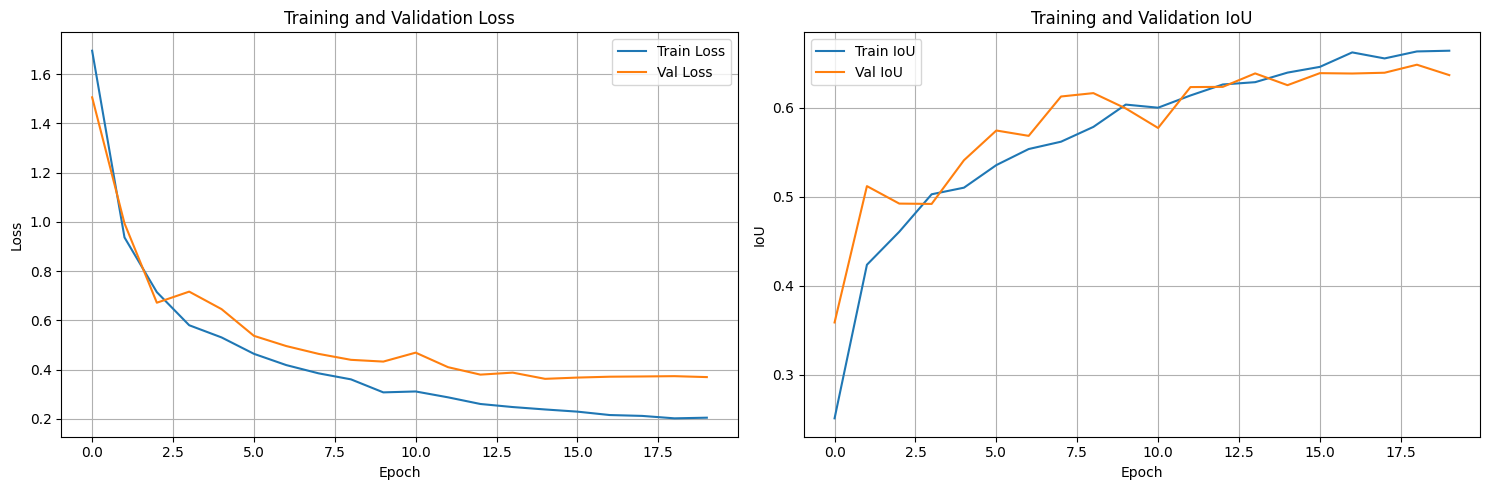


TEST EVALUATION PIPELINE

Loading checkpoint: /kaggle/working/checkpoints/best_model_unet_resnet50.pth
test dataset: 232 samples
Test dataset: 232 samples


Evaluating on test set...


Testing: 100%|██████████| 29/29 [00:12<00:00,  2.35it/s]



TEST RESULTS

Mean IoU: 0.6207

Per-Class IoU:
------------------------------------------------------------
Road                : 0.9066
Sidewalk            : 0.7883
Building            : 0.7984
Pole                : 0.2211
TrafficLight        : 0.5446
TrafficSign         : 0.3178
Vegetation          : 0.7617
Sky                 : 0.9214
Person              : 0.4140
Cyclist             : 0.5857
Vehicle             : 0.8026
Object              : 0.3859

Generating prediction visualizations...

Predictions saved to: /kaggle/working/checkpoints/predictions_visualization.png


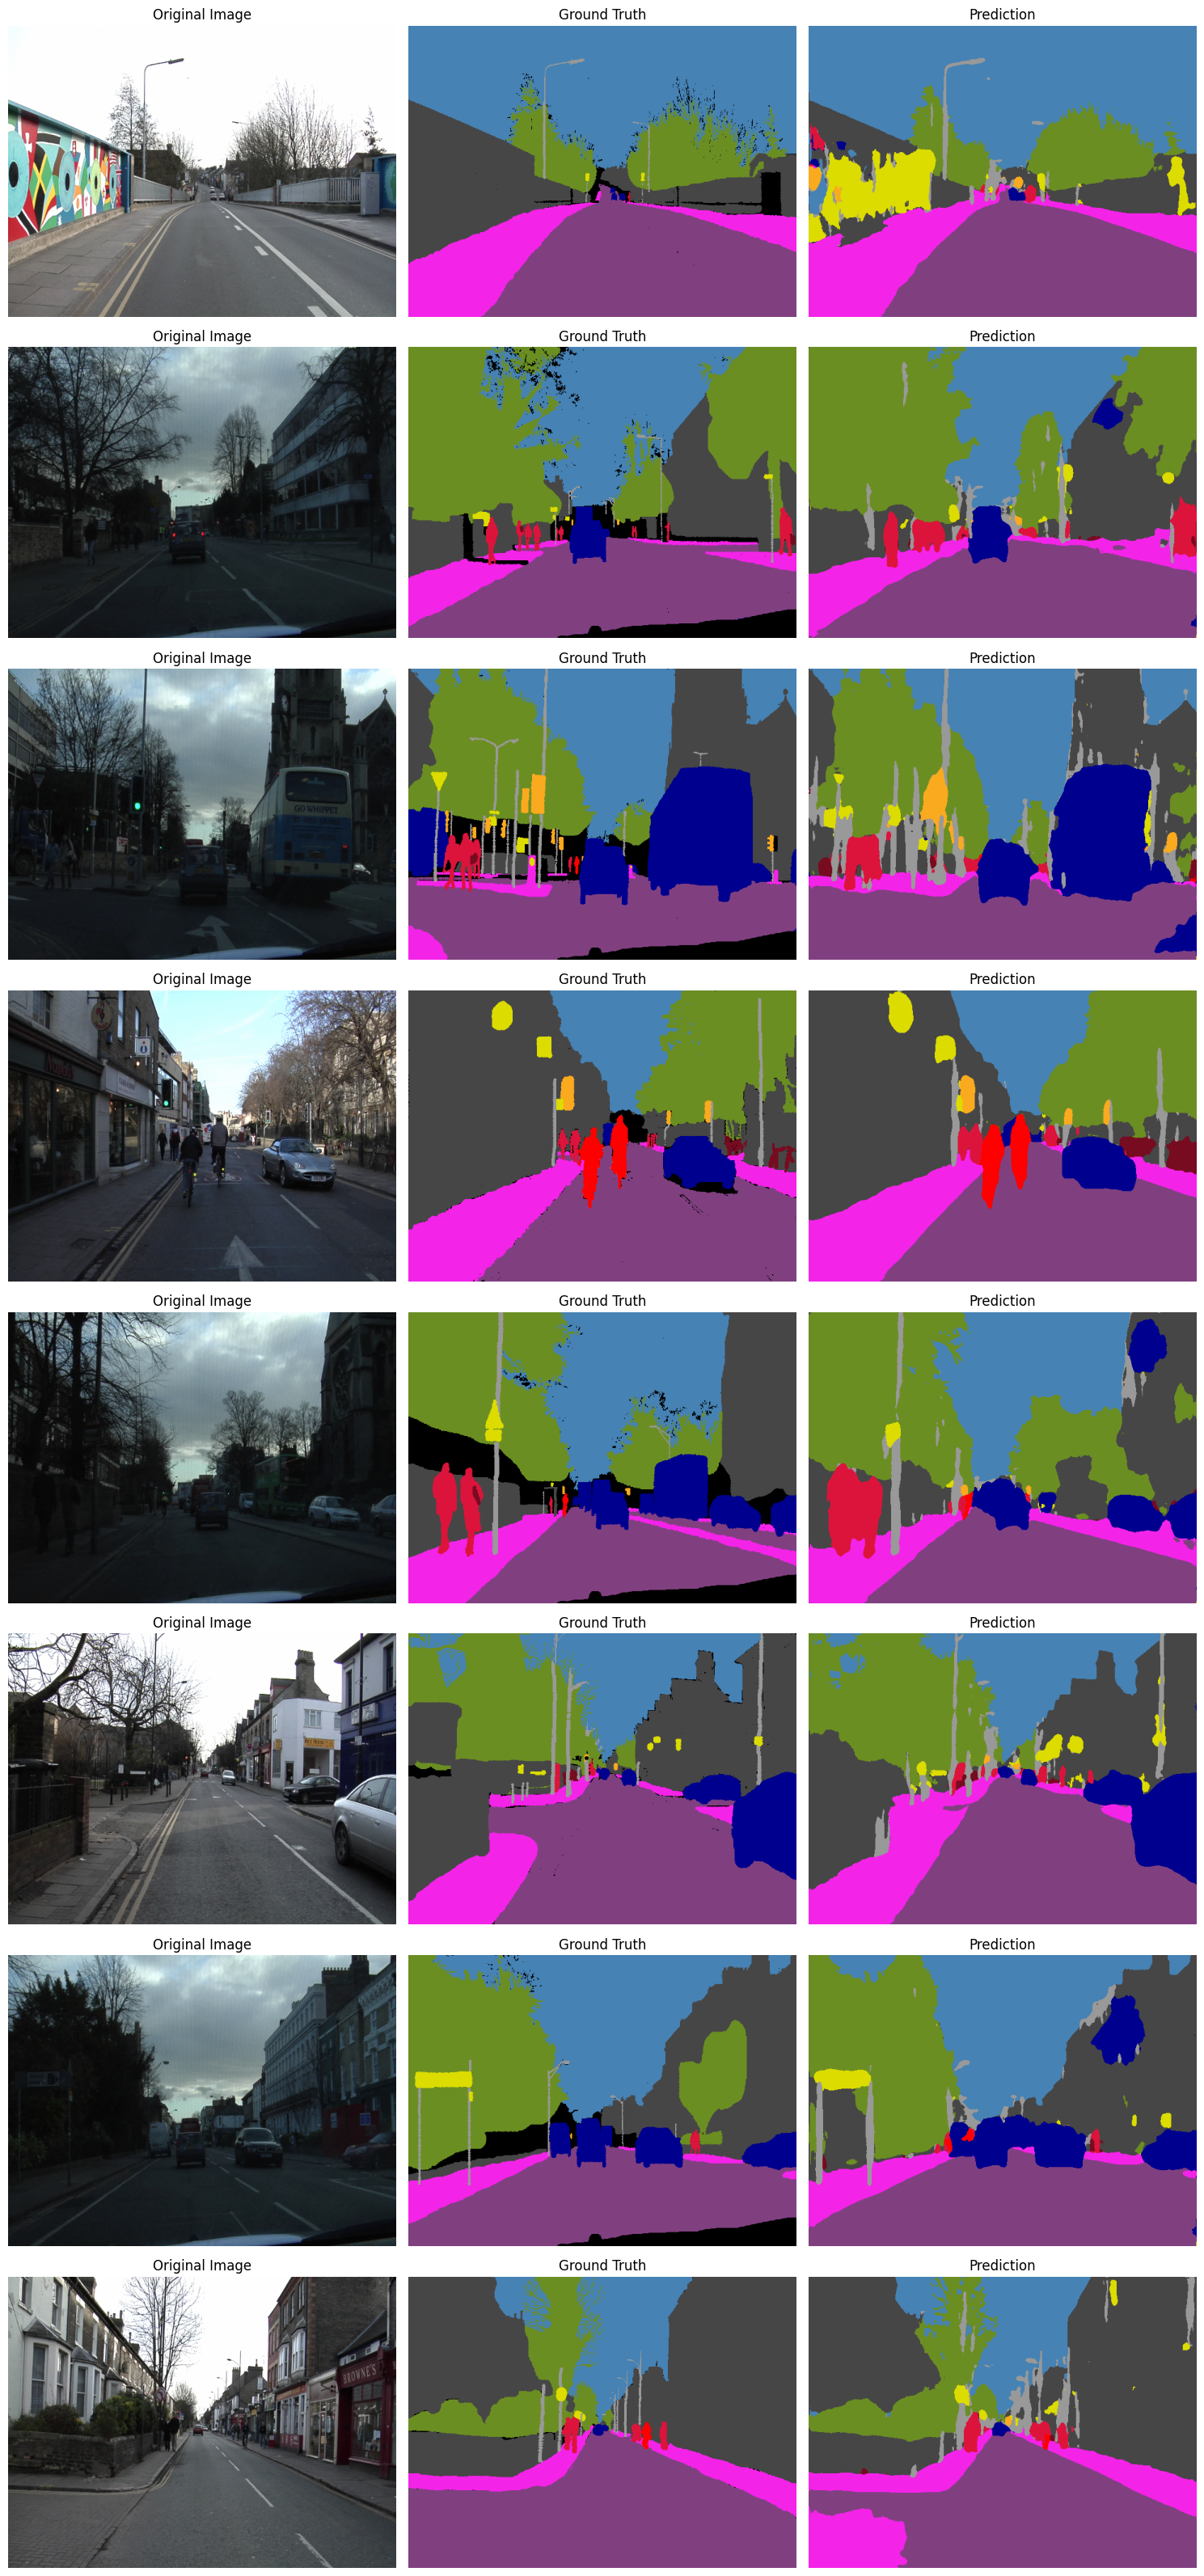


Testing inference speed...

Inference Speed Results:
Average time per batch (8 images): 268.42 ms
FPS: 29.80
Time per image: 33.55 ms

Results saved to: /kaggle/working/checkpoints/test_results.txt

Test evaluation complete!


In [92]:
# Load best hyperparameters from MLflow
experiment = mlflow.get_experiment_by_name("camvid-hyperparam-search")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
best_run = runs_df.loc[runs_df['metrics.best_val_iou'].idxmax()]

print("Best hyperparameters:")
print(f"Learning Rate: {best_run['params.learning_rate']}")
print(f"Batch Size: {best_run['params.batch_size']}")
print(f"Optimizer: {best_run['params.optimizer']}")
print(f"Weight Decay: {best_run['params.weight_decay']}")
print(f"LR Scheduler: {best_run['params.lr_scheduler']}")
print(f"Best Val IoU: {best_run['metrics.best_val_iou']}")

# Reconstruct best hyperparameters
best_hyperparams = {
    'learning_rate': float(best_run['params.learning_rate']),
    'batch_size': int(best_run['params.batch_size']),
    'optimizer': best_run['params.optimizer'],
    'weight_decay': float(best_run['params.weight_decay']),
    'lr_scheduler': best_run['params.lr_scheduler']
}

# Train with best params
model, history = train_model(best_hyperparams)
plot_training_history(history)

# Now test with this model
checkpoint_path = os.path.join(
    Config.CHECKPOINT_DIR,
    f'best_model_{Config.MODEL_NAME}_{Config.ENCODER_NAME}.pth'
)
test_iou, test_class_iou, test_fps = run_test_evaluation(checkpoint_path)

# Testing

In [94]:
# Export MLflow Results

def export_mlflow_results(experiment_name, output_dir):
    """
    Export all MLflow experiment results to CSV and visualize.
    """
    import pandas as pd
    
    # Get experiment
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if not experiment:
        print(f"Experiment '{experiment_name}' not found")
        return
    
    # Get all runs
    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    
    # Select relevant columns
    columns = ['run_id', 'start_time', 'status',
               'params.learning_rate', 'params.batch_size', 'params.optimizer',
               'params.weight_decay', 'params.lr_scheduler',
               'metrics.best_val_iou']
    
    results_df = runs_df[columns].copy()
    results_df = results_df.sort_values('metrics.best_val_iou', ascending=False)
    
    # Save to CSV
    csv_path = os.path.join(output_dir, 'mlflow_results.csv')
    results_df.to_csv(csv_path, index=False)
    print(f"\nResults saved to: {csv_path}")
    
    # Print top 5
    print("\n" + "="*80)
    print("TOP 5 HYPERPARAMETER CONFIGURATIONS")
    print("="*80)
    print(results_df.head(5).to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Learning rate vs IoU
    axes[0, 0].scatter(results_df['params.learning_rate'].astype(float), 
                       results_df['metrics.best_val_iou'])
    axes[0, 0].set_xlabel('Learning Rate')
    axes[0, 0].set_ylabel('Best Val IoU')
    axes[0, 0].set_title('Learning Rate vs IoU')
    axes[0, 0].set_xscale('log')
    
    # Batch size vs IoU
    axes[0, 1].boxplot([results_df[results_df['params.batch_size'] == str(bs)]['metrics.best_val_iou'].dropna() 
                        for bs in [4, 8]], labels=['4', '8'])
    axes[0, 1].set_xlabel('Batch Size')
    axes[0, 1].set_ylabel('Best Val IoU')
    axes[0, 1].set_title('Batch Size vs IoU')
    
    # Optimizer comparison
    optimizer_stats = results_df.groupby('params.optimizer')['metrics.best_val_iou'].mean()
    axes[1, 0].bar(optimizer_stats.index, optimizer_stats.values)
    axes[1, 0].set_xlabel('Optimizer')
    axes[1, 0].set_ylabel('Mean Best Val IoU')
    axes[1, 0].set_title('Optimizer Comparison')
    
    # Weight decay vs IoU
    axes[1, 1].scatter(results_df['params.weight_decay'].astype(float), 
                       results_df['metrics.best_val_iou'])
    axes[1, 1].set_xlabel('Weight Decay')
    axes[1, 1].set_ylabel('Best Val IoU')
    axes[1, 1].set_title('Weight Decay vs IoU')
    axes[1, 1].set_xscale('log')
    
    plt.tight_layout()
    viz_path = os.path.join(output_dir, 'hyperparameter_analysis.png')
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    print(f"Visualization saved to: {viz_path}")
    plt.show()
    
    return results_df

In [95]:

#Export Model for Deployment

def export_model_for_deployment(checkpoint_path, output_dir):
    """
    Export model in multiple formats for easy reuse.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    
    # Create model
    model = create_model(
        Config.MODEL_NAME,
        Config.ENCODER_NAME,
        None,
        Config.NUM_CLASSES
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # 1. Save full model (easiest to load)
    full_model_path = os.path.join(output_dir, 'model_full.pth')
    torch.save(model, full_model_path)
    print(f"Full model saved: {full_model_path}")
    
    # 2. Save state dict only (smaller file)
    state_dict_path = os.path.join(output_dir, 'model_state_dict.pth')
    torch.save(model.state_dict(), state_dict_path)
    print(f"State dict saved: {state_dict_path}")
    
    # 3. Save ONNX format (for production deployment)
    onnx_path = os.path.join(output_dir, 'model.onnx')
    dummy_input = torch.randn(1, 3, Config.IMAGE_HEIGHT, Config.IMAGE_WIDTH)
    torch.onnx.export(model, dummy_input, onnx_path, 
                      input_names=['input'], output_names=['output'],
                      dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
    print(f"ONNX model saved: {onnx_path}")
    
    # 4. Save model config
    config_path = os.path.join(output_dir, 'model_config.txt')
    with open(config_path, 'w') as f:
        f.write(f"Model: {Config.MODEL_NAME}\n")
        f.write(f"Encoder: {Config.ENCODER_NAME}\n")
        f.write(f"Num Classes: {Config.NUM_CLASSES}\n")
        f.write(f"Image Size: {Config.IMAGE_HEIGHT}x{Config.IMAGE_WIDTH}\n")
        f.write(f"Val IoU: {checkpoint['val_iou']:.4f}\n")
    print(f"Config saved: {config_path}")
    
    print("\nModel exported successfully!")
    return full_model_path, state_dict_path, onnx_path




Results saved to: /kaggle/working/checkpoints/mlflow_results.csv

TOP 5 HYPERPARAMETER CONFIGURATIONS
                          run_id                       start_time   status params.learning_rate params.batch_size params.optimizer params.weight_decay params.lr_scheduler  metrics.best_val_iou
7c0cdd830a0e45728f7420718e9ff337 2026-02-16 08:31:04.423000+00:00 FINISHED               0.0005                 8             Adam              0.0001              cosine              0.635323
dd8d90794f8a47baaefbbfa58e185445 2026-02-16 08:49:47.152000+00:00 FINISHED                0.001                 4            AdamW               1e-05              cosine              0.621731
438a53b08c30477aaf7735331ed9b32b 2026-02-16 09:45:35.186000+00:00 FINISHED                0.001                 4            AdamW              0.0001              cosine              0.609772
bd14785352074e52b7f39a665bf15335 2026-02-16 09:08:15.452000+00:00 FINISHED                0.001                 4            

/tmp/ipykernel_55/882995245.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot([results_df[results_df['params.batch_size'] == str(bs)]['metrics.best_val_iou'].dropna()


Visualization saved to: /kaggle/working/checkpoints/hyperparameter_analysis.png


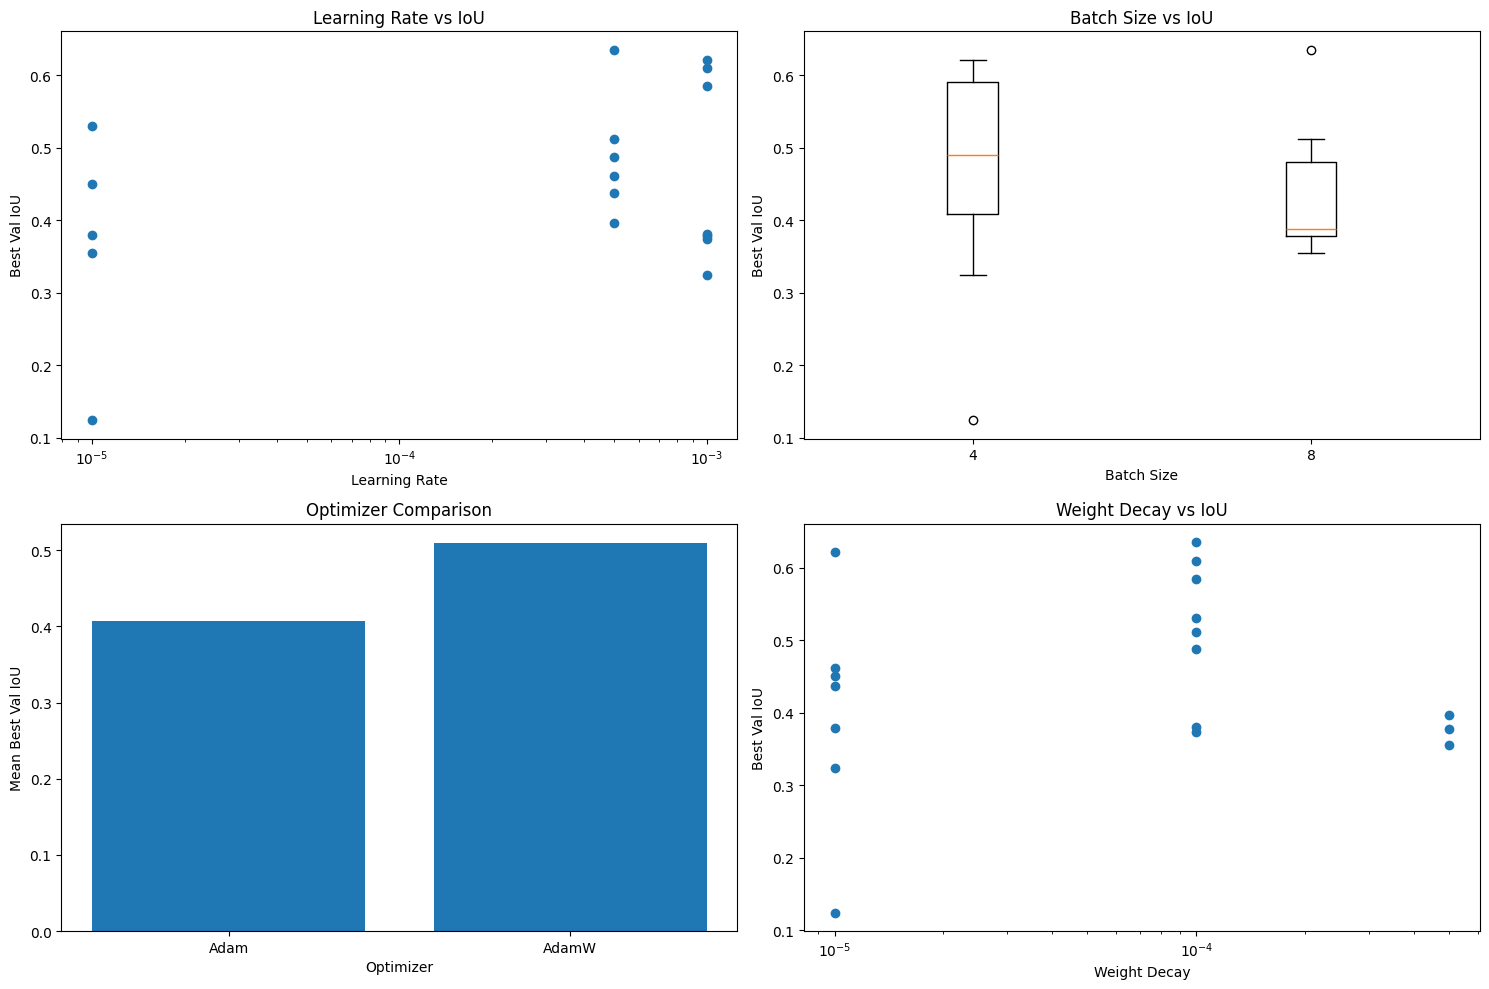

Full model saved: /kaggle/working/checkpoints/model_full.pth
State dict saved: /kaggle/working/checkpoints/model_state_dict.pth


/tmp/ipykernel_55/2890898625.py:35: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy_input, onnx_path,


ONNX model saved: /kaggle/working/checkpoints/model.onnx
Config saved: /kaggle/working/checkpoints/model_config.txt

Model exported successfully!


('/kaggle/working/checkpoints/model_full.pth',
 '/kaggle/working/checkpoints/model_state_dict.pth',
 '/kaggle/working/checkpoints/model.onnx')

In [98]:
#  Export MLflow Results
results_df = export_mlflow_results("camvid-hyperparam-search", Config.CHECKPOINT_DIR)

# Export Model for Deployment
export_model_for_deployment(checkpoint_path, Config.CHECKPOINT_DIR)

In [99]:
import shutil
shutil.make_archive('/kaggle/working/checkpoints_backup', 'zip', '/kaggle/working/checkpoints')

'/kaggle/working/checkpoints_backup.zip'